# ITL Tree Ring Analysis
Author: Johnny Esteves, University Of Michigan

### Description
Here we investigate how the new grid fit code (see: ) changed previous results. For instance, the PSF distortions (i.e. 2nd moment distortions) in the e2v R22-S11 sensor. 

This script is adapted from a notebook by Theo Schutt (Stanford/SLAC) that investigated PSF distortions (i.e. 2nd moment distortions) in the ITL R02-S02 sensor.
The original notebooks can be found in /u/ki/schutt20/notebooks/ on the SLAC cluster.

Also, the SpotgridCatalog is adapted from Sidney Mau, the original codes can be found in /u/ki/smau/projects/camera/spotgrid_analysis/

In [1]:
import os
import glob
import numpy as np
import fitsio as fits
import matplotlib.pyplot as plt

# from scipy.stats import binnedstatistic, binned_statistic_2d

# Load Data

Retrieving files path from BUTLER.

In specific, for loading the results after the corrections made on the mixcoatl code by Alex I use the repo_path used `/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml` and the collection `u/youtsumi/spot/AlexRecommendation`.


### Initialize the `spotgrid.py` code

In [2]:
import sys
sys.path.append('/gpfs/slac/kipac/fs1/u/esteves/codes/treeRingAnalysis/')
from spotgrid_butler import SpotgridCatalog



In [3]:
repo = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml'
itl = SpotgridCatalog(repo,
                      'u/asnyder/spot/itl_analysis',
                      'u/asnyder/spot/itl_calibration',sensor='ITL')

Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
catalog collection: u/asnyder/spot/itl_analysis
calib collection  : u/asnyder/spot/itl_calibration




In [4]:
itl.get_calibration_table()
itl.load_data()
itl.compute_statistics()
itl.compute_spotgrid()
itl.filter_spots()
itl.calibrate()

Found r02_s02_x_arr.npy
Found r02_s02_y_arr.npy
Found r02_s02_xx_arr.npy
Found r02_s02_xy_arr.npy
Found r02_s02_yy_arr.npy
Found r02_s02_dx_arr.npy
Found r02_s02_dy_arr.npy
Found r02_s02_dxx_arr.npy
Found r02_s02_dyy_arr.npy
Found r02_s02_dxy_arr.npy
Found r02_s02_instFlux_arr.npy
Found r02_s02_instFluxErr_arr.npy
Found r02_s02_x_center_arr.npy
Found r02_s02_y_center_arr.npy
Found r02_s02_dFlux_arr.npy
Found r02_s02_dg1_arr.npy
Found r02_s02_dg2_arr.npy
Loading data for ITL r02_s02.
Computing statistics for ITL r02_s02.
Computing filter spots for ITL r02_s02.


In [5]:
np.count_nonzero(np.abs(itl.dXX-itl.dYY)>0)

2105234

# Plot Pointing

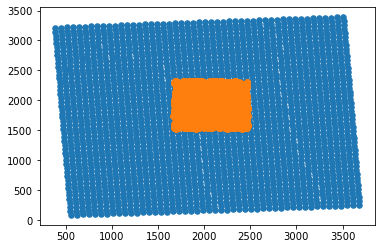

In [6]:
im = plt.scatter(itl.x, itl.y, s=30, marker='o', vmax=0.84)
plt.scatter(itl.x_center[0],itl.y_center[0])

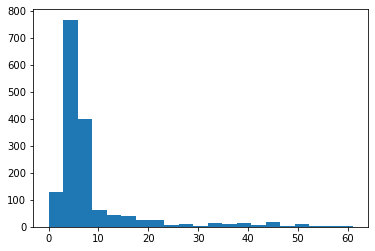

In [7]:
a = plt.hist(itl.nmising,bins=21,label='ITL')

In [8]:
import pylab as plt
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import numpy

# Define a handy plot routine
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [9]:
aref   = itl.catalog_refs[3]
calexp = itl.butler.get("postISRCCD", dataId=aref.dataId, collections=itl.catalog_collection)
src    = itl.butler.get("gridSpotSrc",dataId=aref.dataId, collections=itl.catalog_collection)

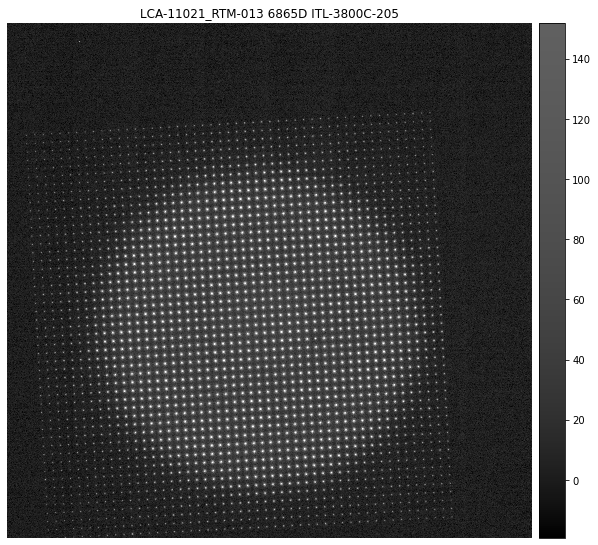

In [10]:
display(calexp,
        " ".join([ calexp.getMetadata()[a] for a in [ "RAFTNAME", "RUNNUM", "LSST_NUM" ] ])
)
# plt.scatter(itl.x_center[0],itl.y_center[0],color='k',s=30)
# plt.scatter(itl.x_center[0][3],itl.y_center[0][3],color='r',s=30)

# Plot Calibration

In [9]:
#import sys
#sys.path.append('/gpfs/slac/kipac/fs1/u/esteves/codes/eotestAnalysis')
from plot_calibration import *

In [10]:
setattr(itl, 'pop', itl.catalog_collection)

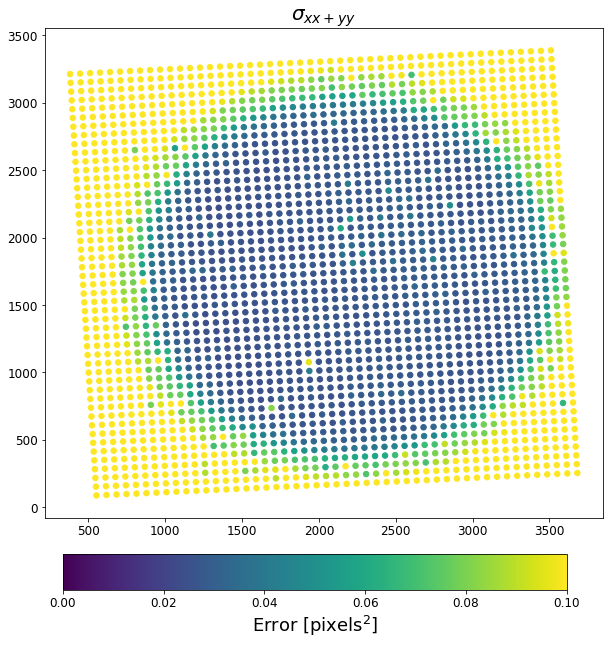

In [11]:
plot_second_moment_spot_err(itl)

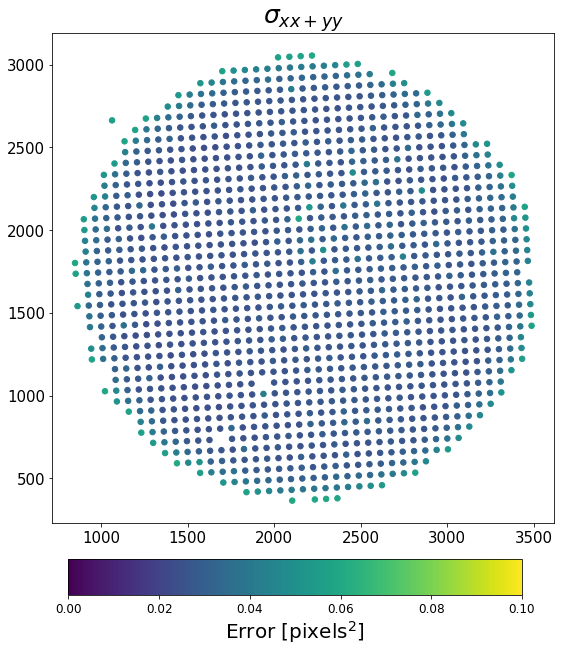

In [14]:
plot_second_moment_sigma(itl)

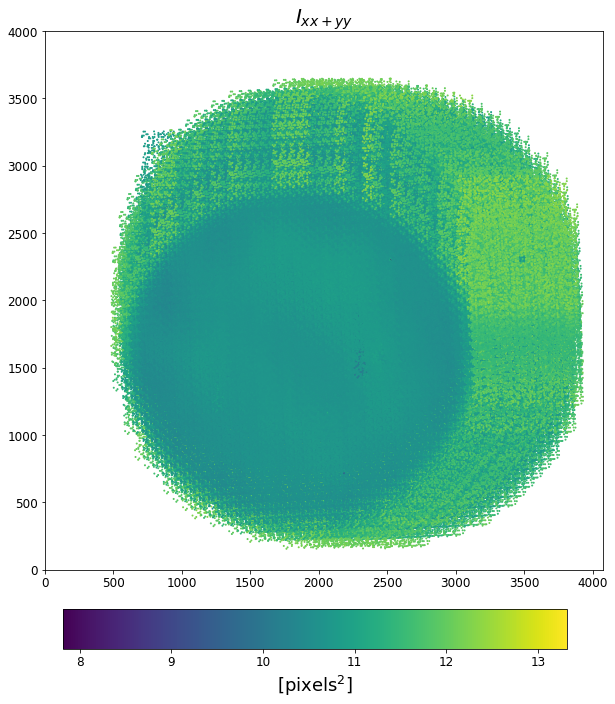

In [15]:
plot_second_moment_sum(itl)

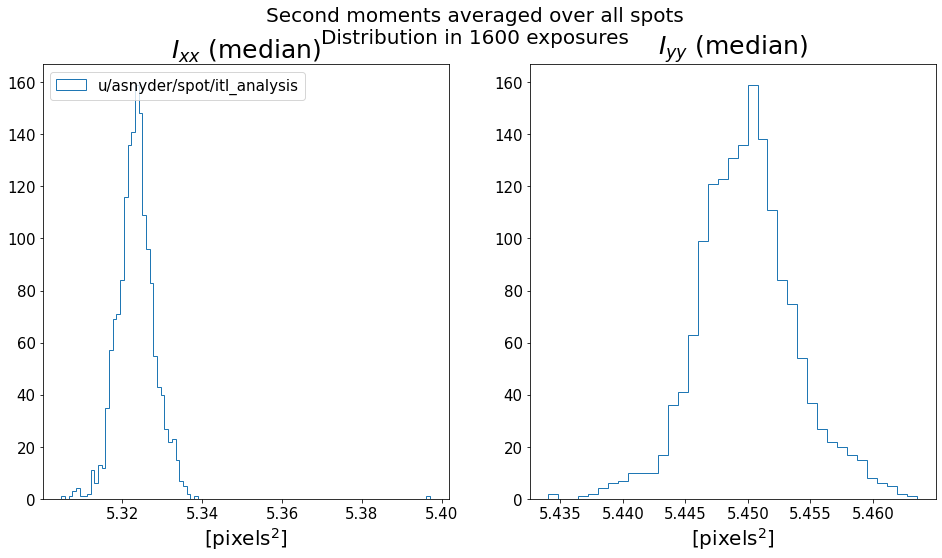

In [16]:
plot_avg_spot_second_moment_hist(itl)

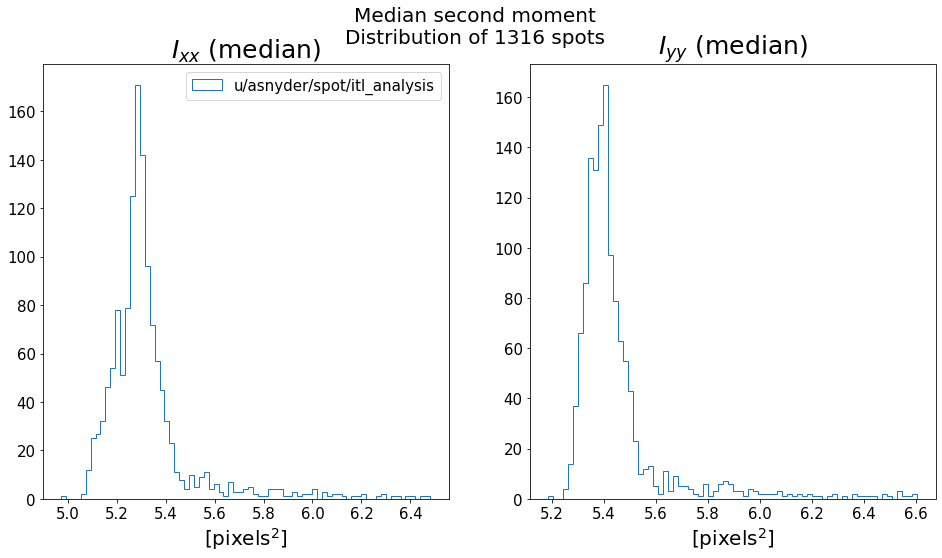

In [17]:
plot_avg_exposure_second_moment_hist(itl)

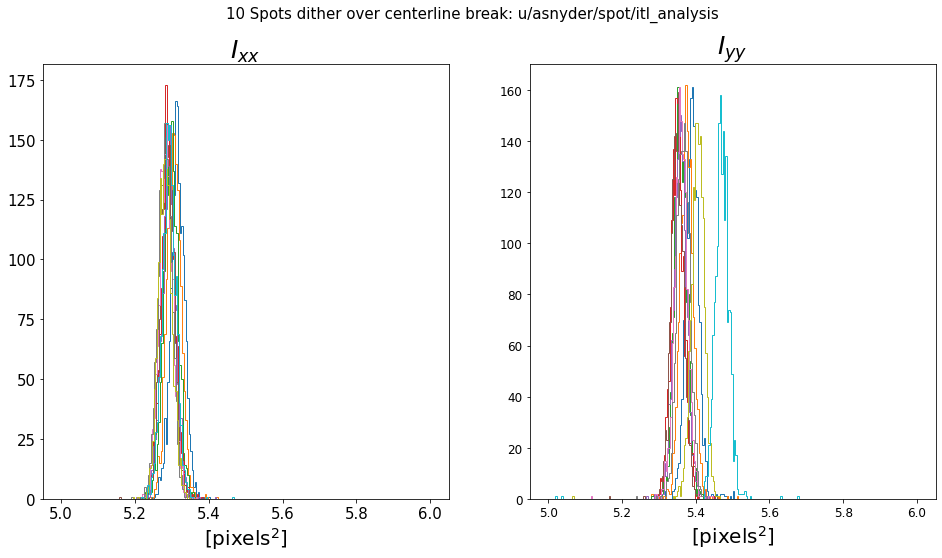

In [18]:
plot_spot_second_moment_hist(itl)

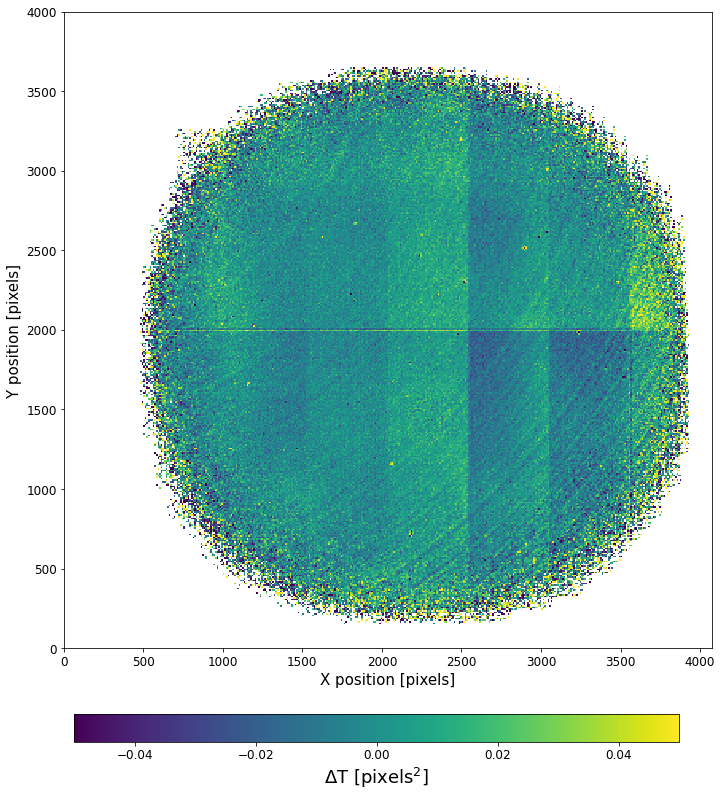

In [19]:
plot_deltaT_heatmap(itl)

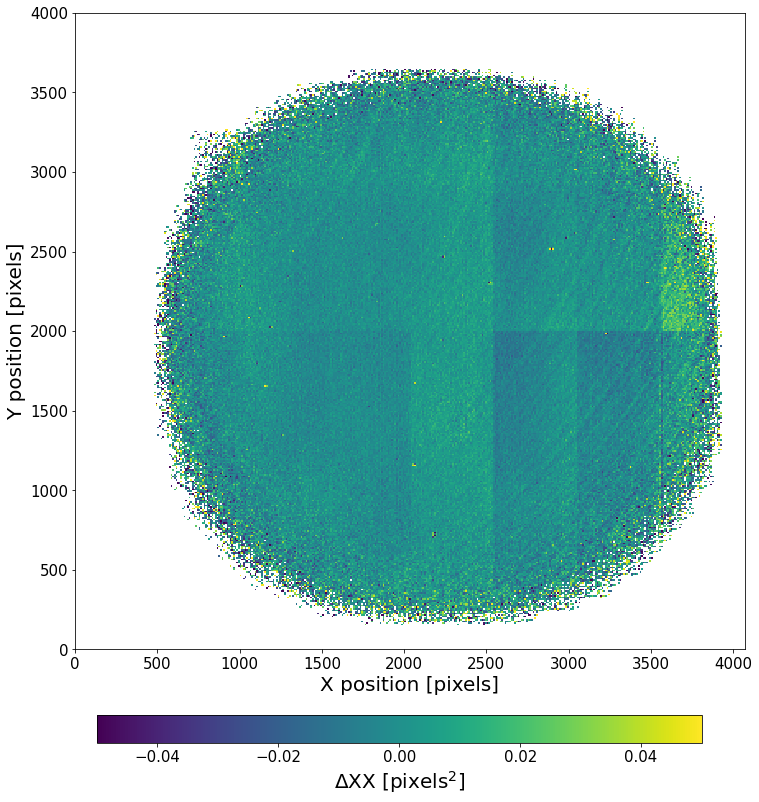

In [20]:
plot_deltaXX_heatmap(itl)

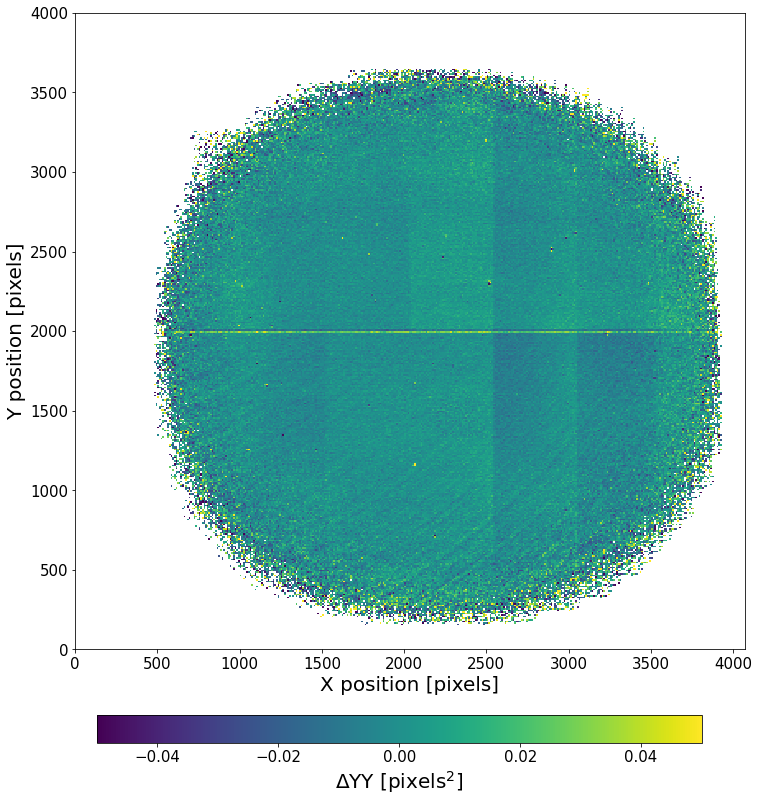

In [21]:
plot_deltaYY_heatmap(itl)

In [22]:
def plot_astrometric_shift_heatmap(sc):
    nbins = 400
    bins = [407,400] #approx. 10x10 px^2 binning
    dT_mean1, x_edge1, y_edge1, binidx = binned_statistic_2d(sc.xfltr_flat, sc.yfltr_flat, sc.dX, 'mean',
                                                          range=[[0,4072],[0,4000]], bins=bins)
                                                          #mean is significantly faster calculation

    dT_mean2, x_edge2, y_edge2, binidx = binned_statistic_2d(sc.xfltr_flat, sc.yfltr_flat, sc.dY, 'mean',
                                                      range=[[0,4072],[0,4000]], bins=bins)
                                                      #mean is significantly faster calculation

    
    #fig, axes = plt.subplots(figsize = (12,13))
    fig, axes = plt.subplots(1, 2, figsize=(16, 8),sharex='all')
    
    xlist = [x_edge1,x_edge2]
    ylist = [y_edge1,y_edge2]
    deltas = [dT_mean1.T,dT_mean2.T]
    for i in range(2):
        x, y = np.meshgrid(xlist[i], ylist[i])
        im0 = axes[i].pcolormesh(x, y, deltas[i], vmin=-0.05, vmax=0.05)
        axes[i].set_xlabel('X position [pixels]', fontsize=15)
        axes[i].set_ylabel('Y position [pixels]', fontsize=15)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].set_aspect('equal')

    fig.subplots_adjust(bottom=0.2)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
    cbar = fig.colorbar(im0, cax= cbar_ax, orientation='horizontal')
    cbar.set_label(r'$\Delta$X_{ii} [$\mathrm{pixels}^2$]', fontsize=18)
    cbar.ax.tick_params(labelsize=12)
    
    axes[0].set_title(r'$\Delta X$',fontsize=20)
    axes[1].set_title(r'$\Delta Y$',fontsize=20)
    plt.suptitle('Astrometric Shifts',fontsize=20)
    plt.show()
    plt.close()


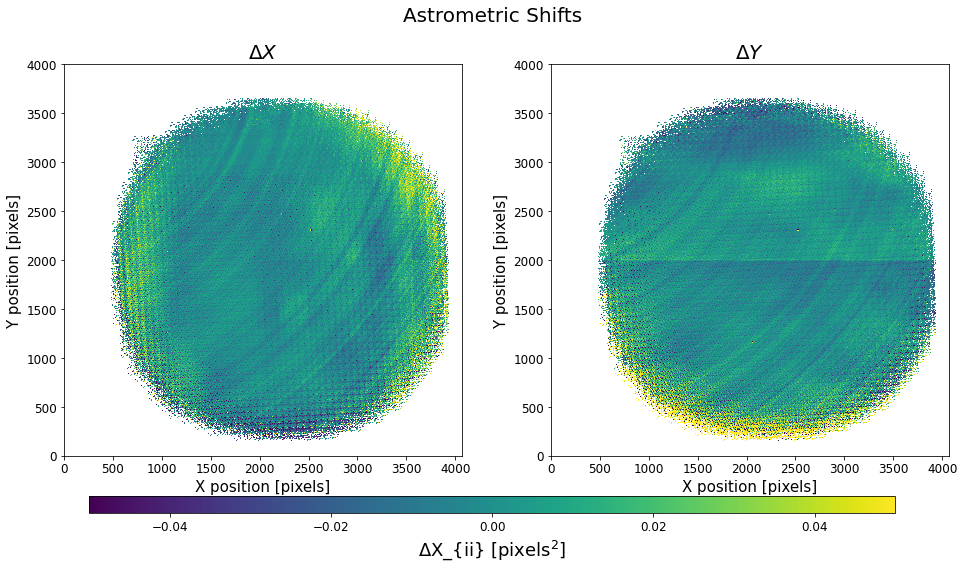

In [23]:
plot_astrometric_shift_heatmap(itl)

In [24]:
def plot_avg_spot_astrometric_shift_hist(sc):
    # This plot shows the histogram for the average of all the spots in each exposure. This basically checks for any anomalous exposures where all the spots are significantly smaller/larger/distorted. There are no such bad exposures.
    
    #averages all spots together for each exposure
    #SM: Note that some of these are available as attributes.
    #    I'm still deciding on how I want to structure this.
    xx_mean_2 = np.nanmedian(sc.deltaX, axis=0)
    yy_mean_2 = np.nanmedian(sc.deltaY, axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].hist(xx_mean_2, bins='auto', histtype='step', label=f'{sc.pop}')
    axes[1].hist(yy_mean_2, bins='auto', histtype='step')
    
    # fig.suptitle('Second moments averaged over all spots\nDistribution of 1600 exposures', fontsize=20)
    axes[0].set_title(r'$\Delta_{x}$ (median)', fontsize=25)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)
    axes[0].set_xlabel(r'[$\mathrm{pixels}^2$]', fontsize=20)
    
    axes[1].set_title(r'$\Delta_{y}$ (median)', fontsize=25)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)
    axes[1].set_xlabel(r'[$\mathrm{pixels}^2$]', fontsize=20)
    
    #plt.suptitle(f'{sc.pop} ',fontsize=15)
    axes[0].legend(loc=2,fontsize=15)
    plt.suptitle('Astrometric Shifts averaged over all spots\nDistribution in 1600 exposures', fontsize=20)

    plt.show()
    plt.close()


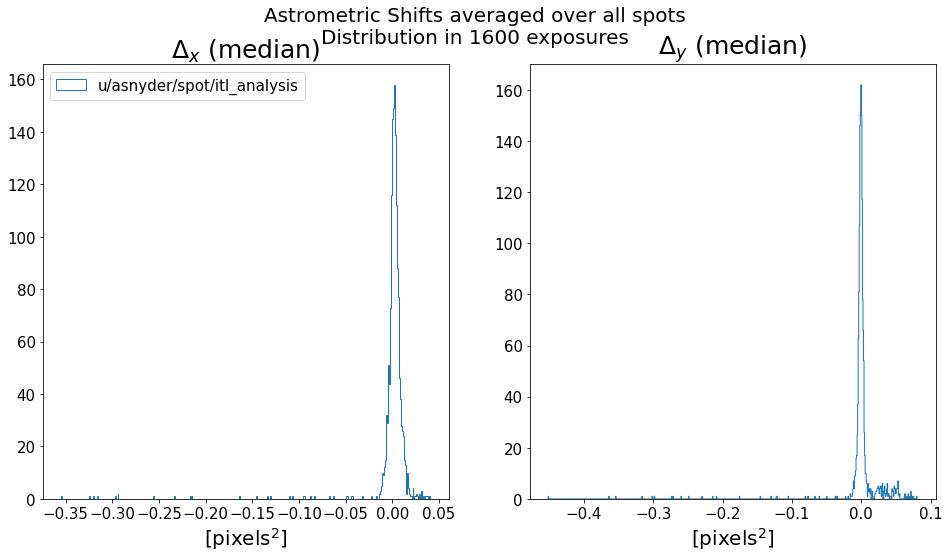

In [25]:
plot_avg_spot_astrometric_shift_hist(itl)

In [26]:
def plot_avg_exposure_astrometric_shift_hist(sc):
    # This plot shows the distribution of each 2nd moment for all the spots. We see there is a large number of spots with 2.25-2.4 px^2 moments and a tail of larger spots. We will see below that these are the spots outside of the focus of the projector lens.
    
    #averages all exposures together for each spot
    #SM: I'm wary of this call... unsure if these are supposed to be means,
    #    or if it was just easier to copy/paste code without changing
    #    the variable names...
    xx_mean_2 = np.nanmedian(sc.deltaX, axis=1)
    yy_mean_2 = np.nanmedian(sc.deltaY, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].hist(xx_mean_2, bins='auto', histtype='step',label=f'{sc.pop}')
    axes[1].hist(yy_mean_2, bins='auto', histtype='step')
    
    axes[0].set_title(r'$\Delta_{x}$ (median)', fontsize=25)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)
    axes[0].set_xlabel(r'[$\mathrm{pixels}^2$]', fontsize=20)
    
    axes[1].set_title(r'$\Delta_{y}$ (median)', fontsize=25)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)
    axes[1].set_xlabel(r'[$\mathrm{pixels}^2$]', fontsize=20)
    
    axes[0].legend(fontsize=15)
    fig.suptitle('Median astrometric shift\nDistribution of %i spots'%(sc.xx_med_3.size), fontsize=20)
    plt.show()
    plt.close()


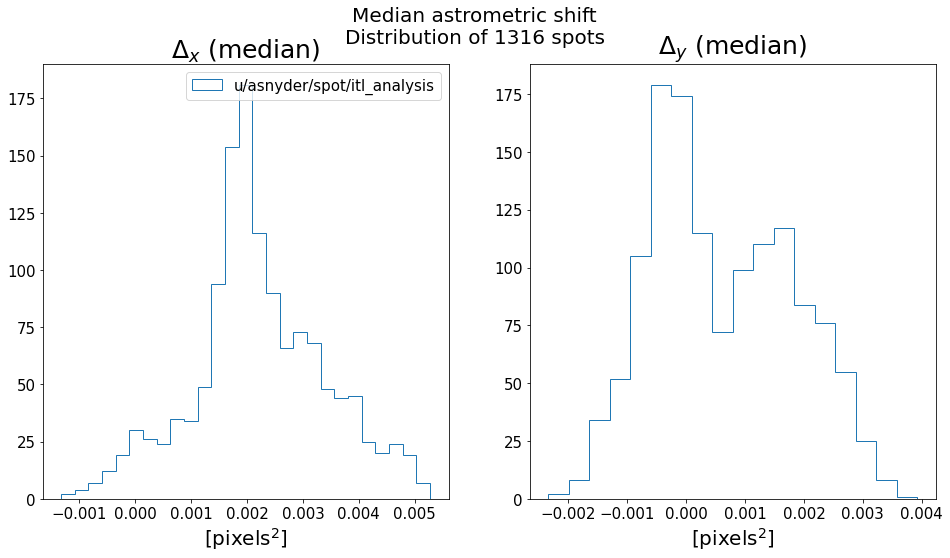

In [27]:
plot_avg_exposure_astrometric_shift_hist(itl)

In [29]:
def plot_avg_exposure_delta_g_hist(sc):    
    #averages all exposures together for each spot
    #SM: I'm wary of this call... unsure if these are supposed to be means,
    #    or if it was just easier to copy/paste code without changing
    #    the variable names...
    xx_mean_2 = np.nanmedian(sc.deltag1, axis=1)
    yy_mean_2 = np.nanmedian(sc.deltag2, axis=1)
    
    axes[1].hist(yy_mean_2, bins='auto', histtype='step')
    
    axes[0].set_title(r'$\Delta{g1}$ (median)', fontsize=25)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)
    #axes[0].set_xlabel(r'[$\mathrm{pixels}^2$]', fontsize=20)
    
    axes[1].set_title(r'$\Delta{g2}$ (median)', fontsize=25)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)
    #axes[1].set_xlabel(r'[$\mathrm{pixels}^2$]', fontsize=20)
    
    axes[0].legend(fontsize=15)
    fig.suptitle('Median ellipticity\nDistribution of %i spots'%(sc.xx_med_3.size), fontsize=20)
    plt.show()
    plt.close()


Text(0.5, 0, '$\\Delta$ instFlux')

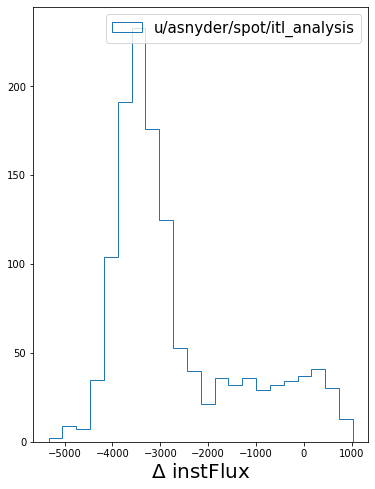

In [38]:
xx_mean_2 = np.nanmedian(itl.deltaF, axis=1)

fig, axes = plt.subplots(1, 1, figsize=(6, 8))
_ = axes.hist(xx_mean_2, bins='auto', histtype='step',label=f'{itl.pop}')
plt.legend(fontsize=15)
axes.set_xlabel(r'$\Delta$ instFlux',fontsize=20)

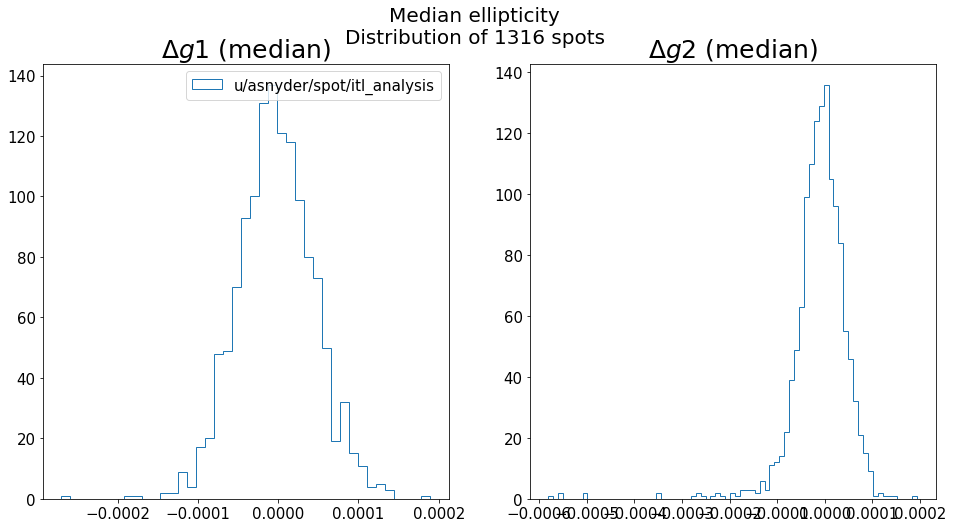

In [30]:
plot_avg_exposure_delta_g_hist(itl)

Text(0, 0.5, 'Y [pixels]')

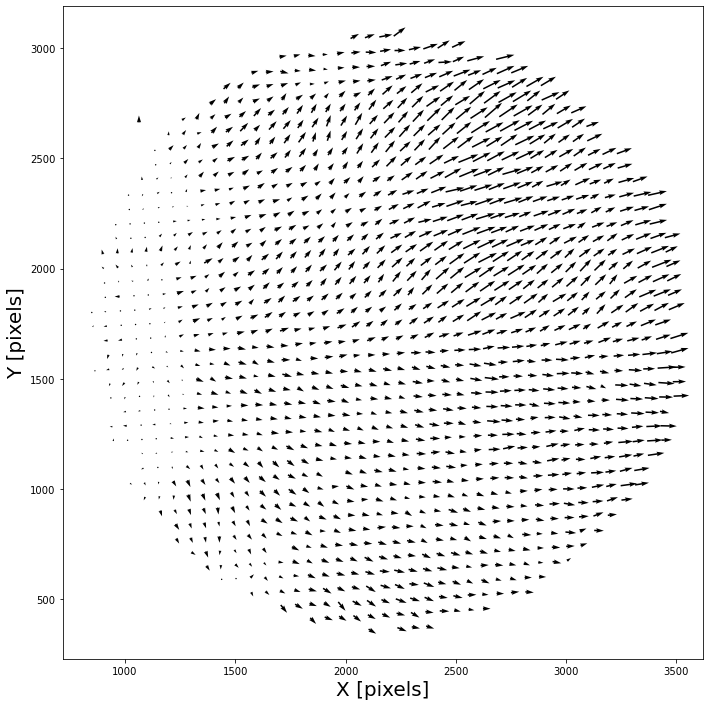

In [41]:
x, y = itl.x[itl.spot_filter],itl.y[itl.spot_filter]
dx = np.nanmedian(itl.deltaX, axis=1)
dy = np.nanmedian(itl.deltaY, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.quiver(x, y, dx, dy)
ax.set_aspect('equal')
ax.set_xlabel('X [pixels]',fontsize=20)
ax.set_ylabel('Y [pixels]',fontsize=20)

# Profile Plots

The below function creates a binned profile of the data (e.g. deltaT, deltaXX , etc) as a function of position. This function is similar, but not equivalent, to scipy.stats.binned_statistic(). There is a factor of 1/sqrt(N) for each bin in the mkProfile() function.

In [45]:
def mkProfile(xarr,yarr,nx=100,xmin=None, xmax=None, ymin=None, ymax=None,retPlot=False):
    if xarr.size==0:
        return np.nan,np.nan,np.nan,np.nan
    if xmin is None:
        xmin = xarr.min()
    if xmax is None:
        xmax = xarr.max()
    if ymin is None:
        ymin = yarr.min()
    if ymax is None:
        ymax = yarr.max()
    
    dx = (xmax-xmin)/nx
    bins = np.arange(xmin,xmax+dx,dx)
    nbin = len(bins)-1
    #print(dx,bins,nbin)
    inrange = (yarr>=ymin) & (yarr<ymax)
    yinrange = yarr[inrange]
    xinrange = xarr[inrange]
    ind = np.digitize(xinrange,bins) - 1.   #np.digitize starts at bin=1
    xval = np.zeros(nbin)
    xerr = np.zeros(nbin)
    yval = np.zeros(nbin)
    yerr = np.zeros(nbin)
    for i in range(nbin):
        inbin = (ind==i)
        xinbin = xinrange[inbin]
        yinbin = yinrange[inbin]
        nentries = len(yinbin)
        xval[i] = 0.5*(bins[i+1]+bins[i])
        xerr[i] = 0.5*(bins[i+1]-bins[i])
        if nentries>0:
            yval[i] = np.mean(yinbin)
            yerr[i] = np.std(yinbin)/np.sqrt(nentries)
            #print(i,xval[i],xerr[i],yval[i],yerr[i])
    if retPlot:
        profile = plt.errorbar(xval,yval,xerr=xerr,yerr=yerr)
        return profile
    else:
        return xval,yval,xerr,yerr

In [46]:
#set up amplifier masks
# e2v segment is 2002 px (parallel) x 512 px (serial)
# serial register is 522 - 10 prescan pixels wide 
# (i.e. 512 active pixels)

def return_amplifier_mask(self,flip=False,px_start = 0):
    self.top_amp_mask = self.yfltr_flat > 2002
    self.bottom_amp_mask = self.yfltr_flat <= 2002

    # e2v serial register is 522 - 10 prescan pixels wide 
    # (i.e. 512 active pixels)
    width = 424
    #px_start = 0
    px_end = px_start+width - 1
    x_amp_list = []
    for amp in range(8):
        amp_mask_lower = self.xfltr_flat >= px_start
        amp_mask_upper = self.xfltr_flat  <= px_end
        amp_mask = amp_mask_lower & amp_mask_upper
        x_amp_list.append(amp_mask)
        px_start += width
        px_end += width
    
    self.x_amp_list = x_amp_list
    if flip:
        self.x_amp_list = list(np.flip(x_amp_list))
    return self

In [47]:
itl_tiles = return_amplifier_mask(itl,px_start=490.)

In [48]:
itl.dT

array([ 0.10516897,  0.02312107, -0.00036963, ..., -0.02523988,
        0.00402919, -0.01376738])

In [49]:
self = itl_tiles

### dT

In [50]:
xbins = 256
ybins = 250
nbins = 200

rad_bins, dT_r_mean, bin_width_r, dT_err1 = mkProfile(self.r, self.dT, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
x_bins, dT_x_top_mean, bin_width_x, dT_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dT[self.top_amp_mask], nx=nbins, 
                                                         xmin=0, xmax=4096)
x_bins, dT_x_bottom_mean, bin_width_x, dT_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dT[self.bottom_amp_mask], 
                                                           nx=nbins, xmin=0, xmax=4096)
y_bins, dT_y_mean, bin_width_y, dT_err4 = mkProfile(self.yfltr_flat, self.dT, nx=nbins, xmin=0, xmax=4002)

In [51]:
np.count_nonzero(np.abs(itl.dXX-itl.dYY)>0)

2105234

### dXX, dYY

In [78]:
nbins = 200

rad_bins, dXX_r_mean, bin_width_r, dXX_err1   = mkProfile(self.r, self.dXX, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
x_bins, dXX_x_top_mean, bin_width_x, dXX_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dXX[self.top_amp_mask], nx=nbins, 
                                                         xmin=0, xmax=4096)
x_bins, dXX_x_bottom_mean, bin_width_x, dXX_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dXX[self.bottom_amp_mask], 
                                                           nx=nbins, xmin=0, xmax=4096)
y_bins, dXX_y_mean, bin_width_y, dXX_err4 = mkProfile(self.yfltr_flat, self.dXX, nx=nbins, xmin=0, xmax=4002)

In [79]:
rad_bins, dYY_r_mean, bin_width_r, dYY_err1 = mkProfile(self.r, self.dYY, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
x_bins, dYY_x_top_mean, bin_width_x, dYY_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dYY[self.top_amp_mask], nx=nbins, 
                                                        xmin=0, xmax=4096)
x_bins, dYY_x_bottom_mean, bin_width_x, dYY_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dYY[self.bottom_amp_mask], 
                                                           nx=nbins, xmin=0, xmax=4096)
y_bins, dYY_y_mean, bin_width_y, dYY_err4 = mkProfile(self.yfltr_flat, self.dYY, nx=nbins, xmin=0, xmax=4002)



In [80]:
rad_bins, dXY_r_mean, bin_width_r, dXY_err1 = mkProfile(self.r, self.dXY, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
x_bins, dXY_x_top_mean, bin_width_x, dXY_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dXY[self.top_amp_mask], nx=nbins, 
                                                        xmin=0, xmax=4096)
x_bins, dXY_x_bottom_mean, bin_width_x, dXY_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dXY[self.bottom_amp_mask], 
                                                           nx=nbins, xmin=0, xmax=4096)
y_bins, dXY_y_mean, bin_width_y, dXY_err4 = mkProfile(self.yfltr_flat, self.dXY, nx=nbins, xmin=0, xmax=4002)

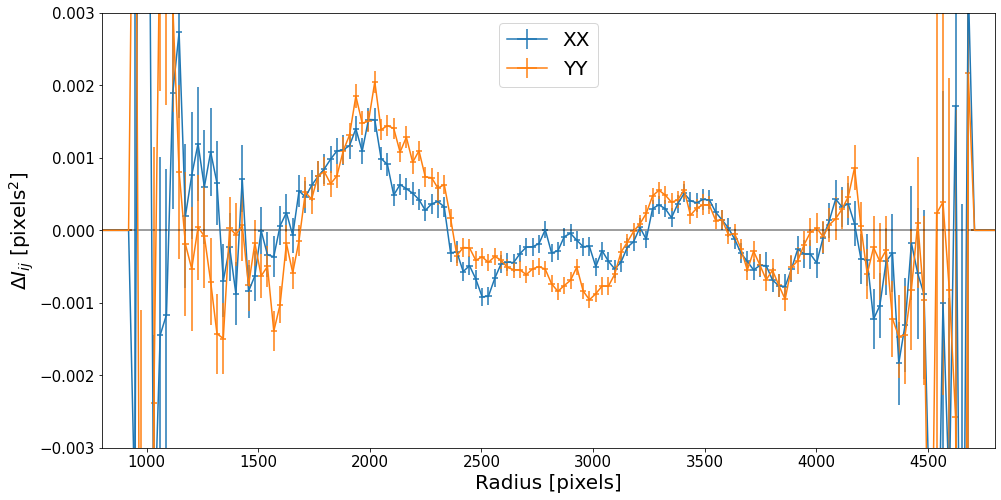

In [81]:
# nbins = 200
fig, axes = plt.subplots(1,1, figsize = (16,8))
x_axis=np.linspace(0,4000*np.sqrt(2),150)

axes.errorbar(rad_bins, dXX_r_mean, xerr=bin_width_r, yerr=dXX_err1, label='XX')
axes.errorbar(rad_bins, dYY_r_mean, xerr=bin_width_r, yerr=dYY_err1, label='YY')
#axes.errorbar(rad_bins, dXY_r_mean, xerr=bin_width_r, yerr=dXY_err1, label='XY')
axes.plot(x_axis, x_axis*0, c='k', alpha=0.5)
# axes[0].set_title(r'$\Delta$2nd moment vs. Radial distance from tree ring center', fontsize=20)
axes.set_xlabel('Radius [pixels]', fontsize=20)
axes.set_ylabel(r'$\Delta I_{ij}$ [pixels$^2$]', fontsize=20)
axes.set_xlim((800, 4800))
axes.set_ylim((-0.003, 0.003))
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.legend(loc='upper center', fontsize=20)


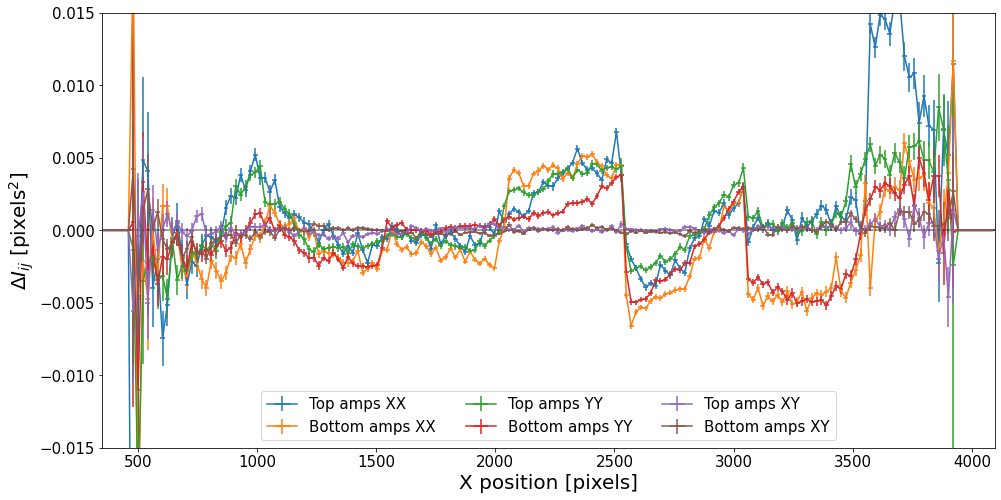

In [56]:
fig, axes = plt.subplots(1,1, figsize = (16,8))

axes.errorbar(x_bins, dXX_x_top_mean, xerr=bin_width_x, yerr=dXX_err2, label='Top amps XX')
axes.errorbar(x_bins, dXX_x_bottom_mean, xerr=bin_width_x, yerr=dXX_err3, label='Bottom amps XX')
axes.errorbar(x_bins, dYY_x_top_mean, xerr=bin_width_x, yerr=dYY_err2, label='Top amps YY')
axes.errorbar(x_bins, dYY_x_bottom_mean, xerr=bin_width_x, yerr=dYY_err3, label='Bottom amps YY')
axes.errorbar(x_bins, dXY_x_top_mean, xerr=bin_width_x, yerr=dXY_err2, label='Top amps XY')
axes.errorbar(x_bins, dXY_x_bottom_mean, xerr=bin_width_x, yerr=dXY_err3, label='Bottom amps XY')
axes.plot(x_axis, x_axis*0, c='k', alpha=0.5)
# axes.set_title(r'$\Delta$2nd moment vs. X', fontsize=20)
axes.set_xlabel('X position [pixels]', fontsize=20)
axes.set_ylabel(r'$\Delta I_{ij}$ [pixels$^2$]', fontsize=20)
axes.set_xlim((350, 4096))
axes.set_ylim((-0.015, 0.015))
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.legend(loc='lower center', fontsize=15, ncol=3)

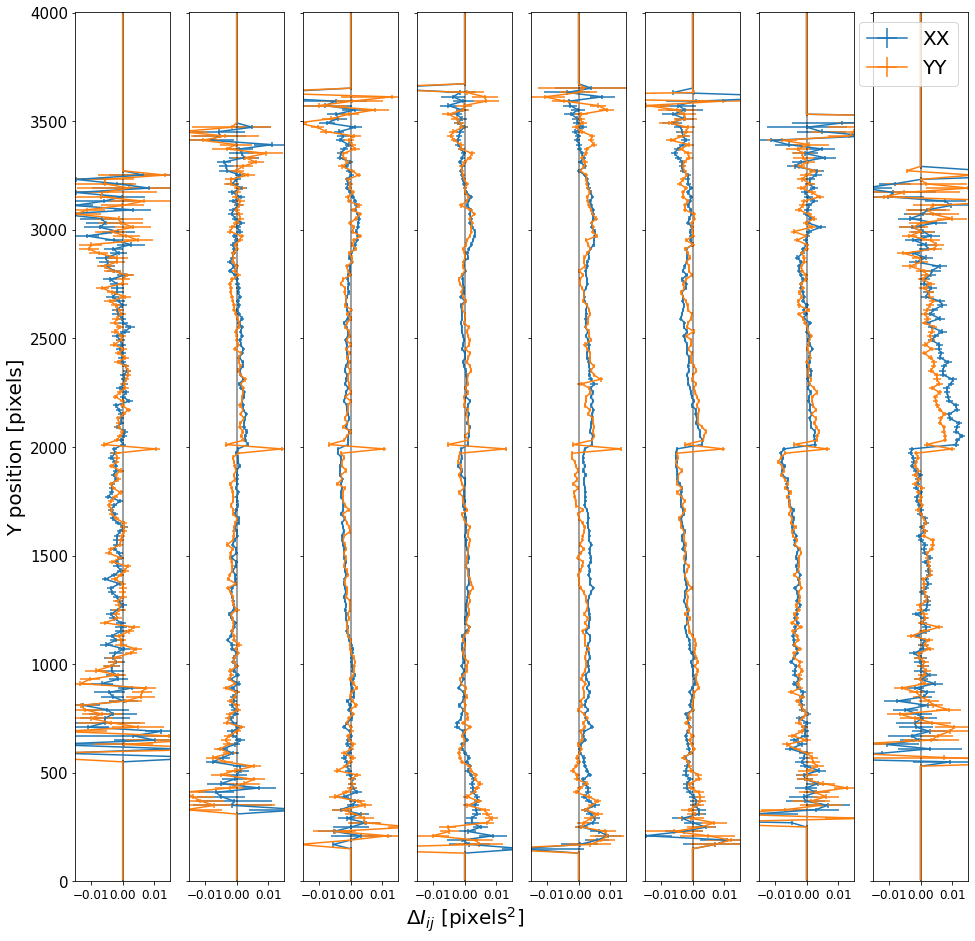

In [57]:
fig2, axes2 = plt.subplots(1, 8, figsize=(16,16))
nbins=200
for i in range(8):
    y_bins, dXX_y_mean, bin_width, dXX_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dXX[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)
    y_bins, dYY_y_mean, bin_width, dYY_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dYY[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)
    y_bins, dXY_y_mean, bin_width, dXY_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dXY[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)

    axes2[i].errorbar(dXX_y_mean, y_bins, yerr=bin_width, xerr=dXX_err4, label='XX')
    axes2[i].errorbar(dYY_y_mean, y_bins, yerr=bin_width, xerr=dYY_err4, label='YY')   
    #axes2[i].errorbar(dXY_y_mean, y_bins, yerr=bin_width, xerr=dXY_err4, label='XY')
    axes2[i].plot(x_axis*0, x_axis, c='k', alpha=0.5)
    axes2[i].set_ylim((0, 4004))
    axes2[i].set_xlim((-0.015, 0.015))
    axes2[i].tick_params(axis='y', labelleft=False)
    axes2[i].tick_params(axis='x', labelsize=12)
    
axes2[0].tick_params(axis='y', labelsize=15, labelleft=True)
axes2[0].set_ylabel('Y position [pixels]', fontsize=20)
# axes2[3].set_title(r'$\Delta$2nd moment vs. Y', fontsize=20)
axes2[3].set_xlabel(r'$\Delta I_{ij}$ [pixels$^2$]', fontsize=20)
axes2[7].legend(loc='upper right', fontsize=20)

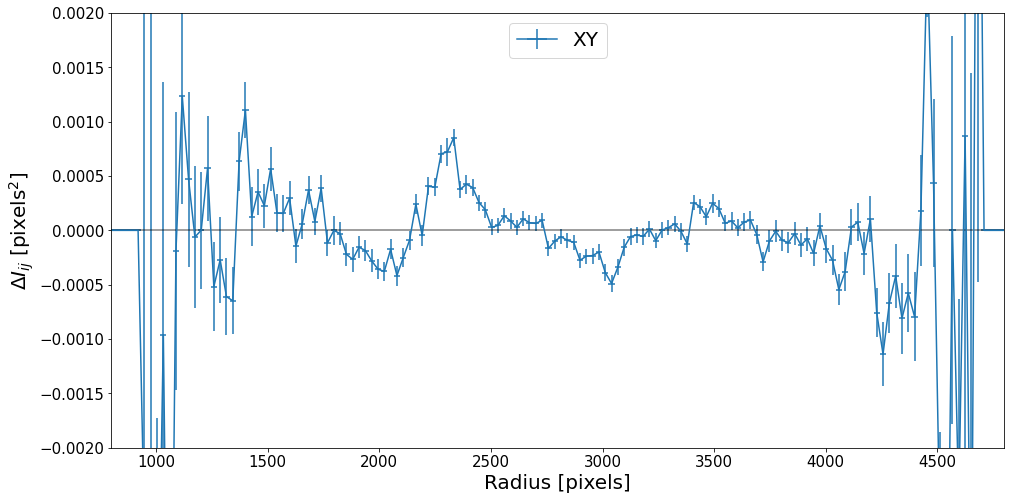

In [69]:
# nbins = 200
fig, axes = plt.subplots(1,1, figsize = (16,8))
x_axis=np.linspace(0,4000*np.sqrt(2),150)

# axes.errorbar(rad_bins, dXX_r_mean, xerr=bin_width_r, yerr=dXX_err1, label='XX')
# axes.errorbar(rad_bins, dYY_r_mean, xerr=bin_width_r, yerr=dYY_err1, label='YY')
axes.errorbar(rad_bins, dXY_r_mean, xerr=bin_width_r, yerr=dXY_err1, label='XY')
axes.plot(x_axis, x_axis*0, c='k', alpha=0.5)
# axes[0].set_title(r'$\Delta$2nd moment vs. Radial distance from tree ring center', fontsize=20)
axes.set_xlabel('Radius [pixels]', fontsize=20)
axes.set_ylabel(r'$\Delta I_{ij}$ [pixels$^2$]', fontsize=20)
axes.set_xlim((800, 4800))
axes.set_ylim((-0.002, 0.002))
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.legend(loc='upper center', fontsize=20)


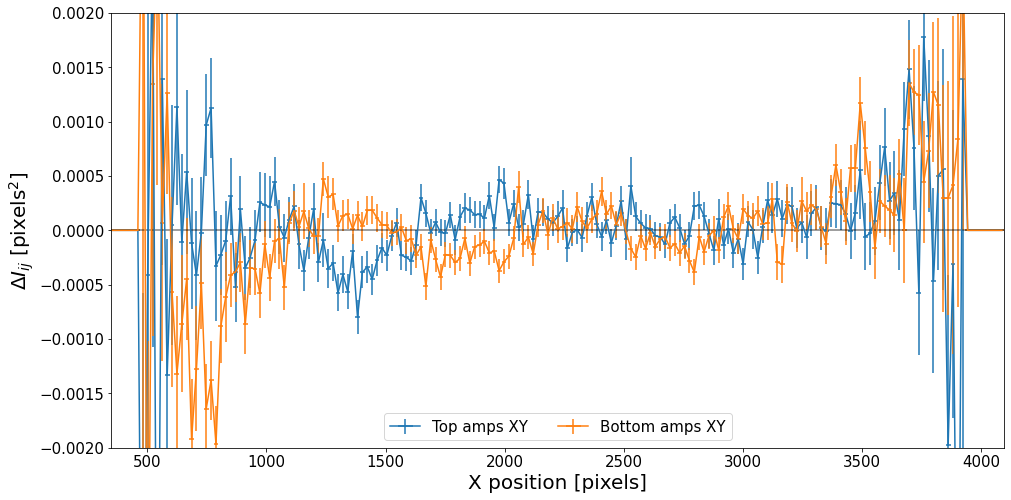

In [70]:
fig, axes = plt.subplots(1,1, figsize = (16,8))

# axes.errorbar(x_bins, dXX_x_top_mean, xerr=bin_width_x, yerr=dXX_err2, label='Top amps XX')
# axes.errorbar(x_bins, dXX_x_bottom_mean, xerr=bin_width_x, yerr=dXX_err3, label='Bottom amps XX')
# axes.errorbar(x_bins, dYY_x_top_mean, xerr=bin_width_x, yerr=dYY_err2, label='Top amps YY')
# axes.errorbar(x_bins, dYY_x_bottom_mean, xerr=bin_width_x, yerr=dYY_err3, label='Bottom amps YY')
axes.errorbar(x_bins, dXY_x_top_mean, xerr=bin_width_x, yerr=dXY_err2, label='Top amps XY')
axes.errorbar(x_bins, dXY_x_bottom_mean, xerr=bin_width_x, yerr=dXY_err3, label='Bottom amps XY')
axes.plot(x_axis, x_axis*0, c='k', alpha=0.5)
# axes.set_title(r'$\Delta$2nd moment vs. X', fontsize=20)
axes.set_xlabel('X position [pixels]', fontsize=20)
axes.set_ylabel(r'$\Delta I_{ij}$ [pixels$^2$]', fontsize=20)
axes.set_xlim((350, 4096))
axes.set_ylim((-0.002, 0.002))
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.legend(loc='lower center', fontsize=15, ncol=3)

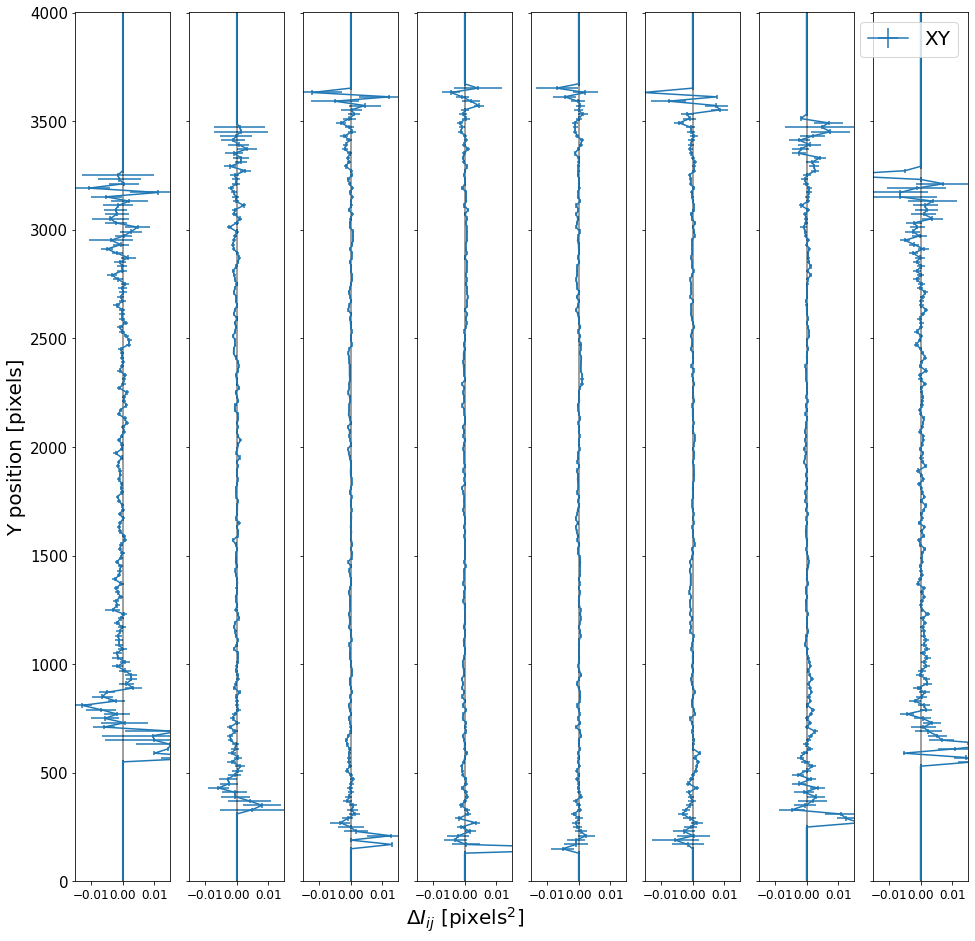

In [60]:
fig2, axes2 = plt.subplots(1, 8, figsize=(16,16))
nbins=200
for i in range(8):
    y_bins, dXX_y_mean, bin_width, dXX_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dXX[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)
    y_bins, dYY_y_mean, bin_width, dYY_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dYY[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)
    y_bins, dXY_y_mean, bin_width, dXY_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dXY[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)

    #axes2[i].errorbar(dXX_y_mean, y_bins, yerr=bin_width, xerr=dXX_err4, label='XX')
    #axes2[i].errorbar(dYY_y_mean, y_bins, yerr=bin_width, xerr=dYY_err4, label='YY')   
    axes2[i].errorbar(dXY_y_mean, y_bins, yerr=bin_width, xerr=dXY_err4, label='XY')
    axes2[i].plot(x_axis*0, x_axis, c='k', alpha=0.5)
    axes2[i].set_ylim((0, 4004))
    axes2[i].set_xlim((-0.015, 0.015))
    axes2[i].tick_params(axis='y', labelleft=False)
    axes2[i].tick_params(axis='x', labelsize=12)
    
axes2[0].tick_params(axis='y', labelsize=15, labelleft=True)
axes2[0].set_ylabel('Y position [pixels]', fontsize=20)
# axes2[3].set_title(r'$\Delta$2nd moment vs. Y', fontsize=20)
axes2[3].set_xlabel(r'$\Delta I_{ij}$ [pixels$^2$]', fontsize=20)
axes2[7].legend(loc='upper right', fontsize=20)

### Astrometric Shifts

### dXX, dYY

In [61]:
nbins = 200

rad_bins, dX_r_mean, bin_width_r, dX_err1 = mkProfile(self.r, self.dX, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
x_bins, dX_x_top_mean, bin_width_x, dX_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dX[self.top_amp_mask], nx=nbins, 
                                                         xmin=0, xmax=4096)
x_bins, dX_x_bottom_mean, bin_width_x, dX_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dX[self.bottom_amp_mask], 
                                                           nx=nbins, xmin=0, xmax=4096)
y_bins, dX_y_mean, bin_width_y, dX_err4 = mkProfile(self.yfltr_flat, self.dX, nx=nbins, xmin=0, xmax=4002)

In [62]:
rad_bins, dY_r_mean, bin_width_r, dY_err1 = mkProfile(self.r, self.dY, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
x_bins, dY_x_top_mean, bin_width_x, dY_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dY[self.top_amp_mask], nx=nbins, 
                                                        xmin=0, xmax=4096)
x_bins, dY_x_bottom_mean, bin_width_x, dY_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dY[self.bottom_amp_mask], 
                                                           nx=nbins, xmin=0, xmax=4096)
y_bins, dY_y_mean, bin_width_y, dY_err4 = mkProfile(self.yfltr_flat, self.dY, nx=nbins, xmin=0, xmax=4002)



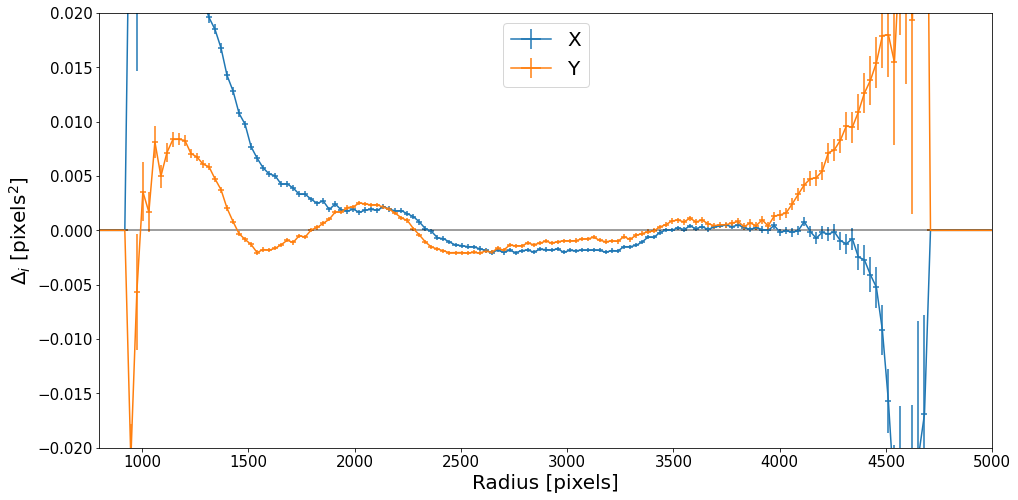

In [72]:
# nbins = 200
fig, axes = plt.subplots(1,1, figsize = (16,8))
x_axis=np.linspace(0,4000*np.sqrt(2),150)

axes.errorbar(rad_bins, dX_r_mean, xerr=bin_width_r, yerr=dX_err1, label='X')
axes.errorbar(rad_bins, dY_r_mean, xerr=bin_width_r, yerr=dY_err1, label='Y')
#axes.errorbar(rad_bins, dXY_r_mean, xerr=bin_width_r, yerr=dXY_err1, label='XY')
axes.plot(x_axis, x_axis*0, c='k', alpha=0.5)
# axes[0].set_title(r'$\Delta$2nd moment vs. Radial distance from tree ring center', fontsize=20)
axes.set_xlabel('Radius [pixels]', fontsize=20)
axes.set_ylabel(r'$\Delta_{i}$ [pixels$^2$]', fontsize=20)
axes.set_xlim((800, 5000))
axes.set_ylim((-0.02, 0.02))
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.legend(loc='upper center', fontsize=20)


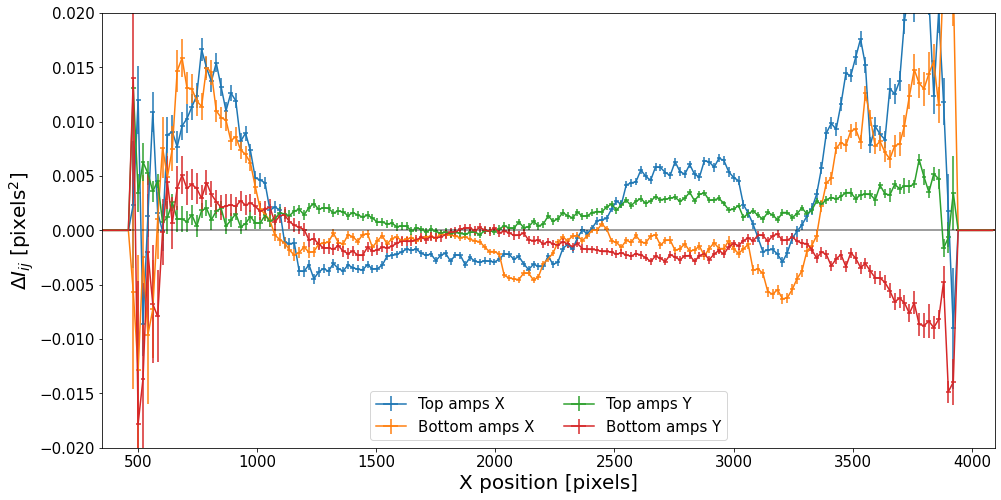

In [82]:
fig, axes = plt.subplots(1,1, figsize = (16,8))

axes.errorbar(x_bins, dX_x_top_mean, xerr=bin_width_x, yerr=dX_err2, label='Top amps X')
axes.errorbar(x_bins, dX_x_bottom_mean, xerr=bin_width_x, yerr=dX_err3, label='Bottom amps X')
axes.errorbar(x_bins, dY_x_top_mean, xerr=bin_width_x, yerr=dY_err2, label='Top amps Y')
axes.errorbar(x_bins, dY_x_bottom_mean, xerr=bin_width_x, yerr=dY_err3, label='Bottom amps Y')
# axes.errorbar(x_bins, dXY_x_top_mean, xerr=bin_width_x, yerr=dXY_err2, label='Top amps XY')
# axes.errorbar(x_bins, dXY_x_bottom_mean, xerr=bin_width_x, yerr=dXY_err3, label='Bottom amps XY')
axes.plot(x_axis, x_axis*0, c='k', alpha=0.5)
# axes.set_title(r'$\Delta$2nd moment vs. X', fontsize=20)
axes.set_xlabel('X position [pixels]', fontsize=20)
axes.set_ylabel(r'$\Delta I_{ij}$ [pixels$^2$]', fontsize=20)
axes.set_xlim((350, 4096))
axes.set_ylim((-0.02, 0.02))
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.legend(loc='lower center', fontsize=15, ncol=2)

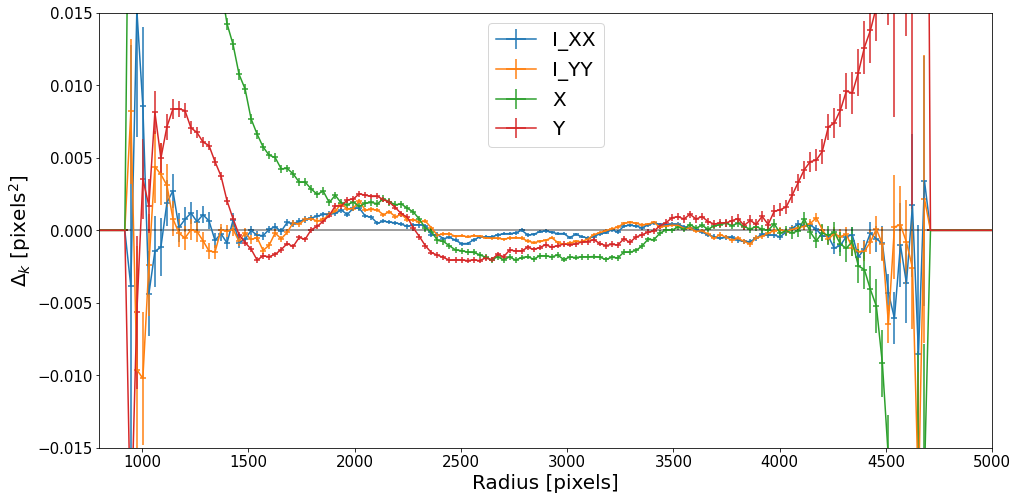

In [83]:
# nbins = 200
fig, axes = plt.subplots(1,1, figsize = (16,8))
x_axis=np.linspace(0,4000*np.sqrt(2),150)

axes.errorbar(rad_bins, dXX_r_mean, xerr=bin_width_r, yerr=dXX_err1, label='I_XX')
axes.errorbar(rad_bins, dYY_r_mean, xerr=bin_width_r, yerr=dYY_err1, label='I_YY')

axes.errorbar(rad_bins, dX_r_mean, xerr=bin_width_r, yerr=dX_err1, label='X')
axes.errorbar(rad_bins, dY_r_mean, xerr=bin_width_r, yerr=dY_err1, label='Y')


axes.plot(x_axis, x_axis*0, c='k', alpha=0.5)
# axes[0].set_title(r'$\Delta$2nd moment vs. Radial distance from tree ring center', fontsize=20)
axes.set_xlabel('Radius [pixels]', fontsize=20)
axes.set_ylabel(r'$\Delta_{k}$ [pixels$^2$]', fontsize=20)
axes.set_xlim((800, 5000))
axes.set_ylim((-0.015, 0.015))
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.legend(loc='upper center', fontsize=20)


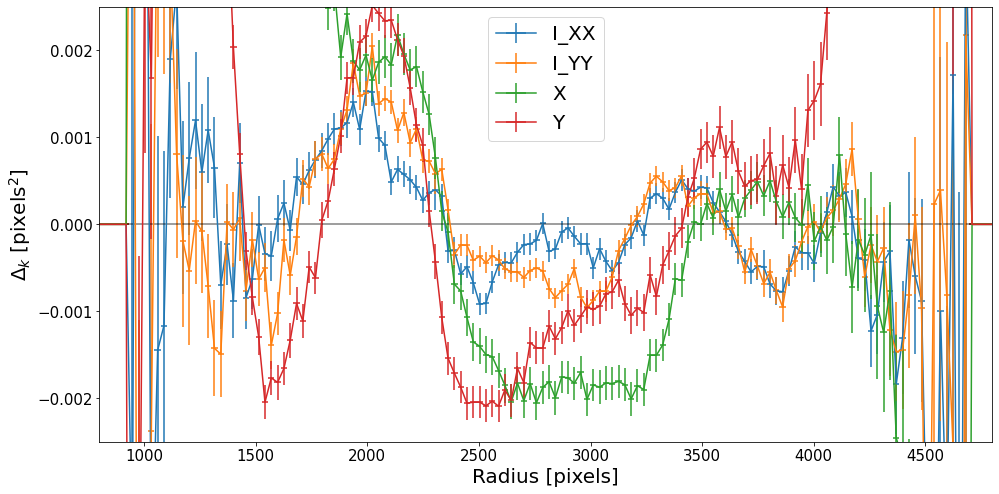

In [84]:
# nbins = 200
fig, axes = plt.subplots(1,1, figsize = (16,8))
x_axis=np.linspace(0,4000*np.sqrt(2),150)

axes.errorbar(rad_bins, dXX_r_mean, xerr=bin_width_r, yerr=dXX_err1, label='I_XX')
axes.errorbar(rad_bins, dYY_r_mean, xerr=bin_width_r, yerr=dYY_err1, label='I_YY')

axes.errorbar(rad_bins, dX_r_mean, xerr=bin_width_r, yerr=dX_err1, label='X')
axes.errorbar(rad_bins, dY_r_mean, xerr=bin_width_r, yerr=dY_err1, label='Y')


axes.plot(x_axis, x_axis*0, c='k', alpha=0.5)
# axes[0].set_title(r'$\Delta$2nd moment vs. Radial distance from tree ring center', fontsize=20)
axes.set_xlabel('Radius [pixels]', fontsize=20)
axes.set_ylabel(r'$\Delta_{k}$ [pixels$^2$]', fontsize=20)
axes.set_xlim((800, 4800))
axes.set_ylim((-0.0025, 0.0025))
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.legend(loc='upper center', fontsize=20)


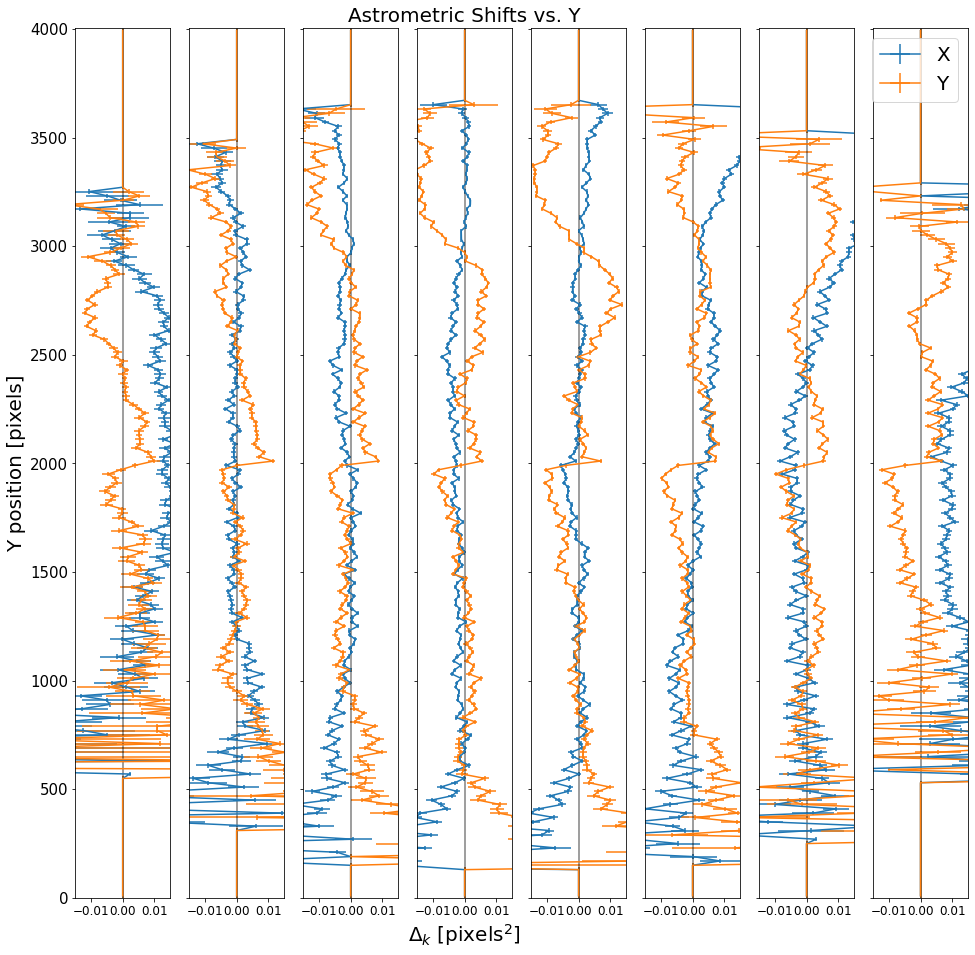

In [66]:
fig2, axes2 = plt.subplots(1, 8, figsize=(16,16))
nbins=200
for i in range(8):
    y_bins, dX_y_mean, bin_width, dX_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dX[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)
    y_bins, dY_y_mean, bin_width, dY_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dY[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)
    y_bins, dX_y_mean, bin_width, dX_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dX[self.x_amp_list[i]], nx=nbins, 
                                                        xmin=0, xmax=4002)

    axes2[i].errorbar(dX_y_mean, y_bins, yerr=bin_width, xerr=dX_err4, label='X')
    axes2[i].errorbar(dY_y_mean, y_bins, yerr=bin_width, xerr=dY_err4, label='Y')   
    #axes2[i].errorbar(dXY_y_mean, y_bins, yerr=bin_width, xerr=dXY_err4, label='XY')
    axes2[i].plot(x_axis*0, x_axis, c='k', alpha=0.5)
    axes2[i].set_ylim((0, 4004))
    axes2[i].set_xlim((-0.015, 0.015))
    axes2[i].tick_params(axis='y', labelleft=False)
    axes2[i].tick_params(axis='x', labelsize=12)
    
axes2[0].tick_params(axis='y', labelsize=15, labelleft=True)
axes2[0].set_ylabel('Y position [pixels]', fontsize=20)
axes2[3].set_title(r'Astrometric Shifts vs. Y', fontsize=20)
axes2[3].set_xlabel(r'$\Delta_{k}$ [pixels$^2$]', fontsize=20)
axes2[7].legend(loc='upper right', fontsize=20)

In [85]:
from scipy.stats import binned_statistic, binned_statistic_2d
import cv2

In [86]:
def plot_deltaT_heatmap_comp(sc):
    nbins = 400
    bins = [407,400] #approx. 10x10 px^2 binning
    dT_mean1, x_edge1, y_edge1, binidx = binned_statistic_2d(sc.xfltr_flat, sc.yfltr_flat, sc.dX, 'mean',
                                                          range=[[0,4072],[0,4000]], bins=bins)
                                                          #mean is significantly faster calculation

    dT_mean2, x_edge2, y_edge2, binidx = binned_statistic_2d(sc.xfltr_flat, sc.yfltr_flat, sc.dY, 'mean',
                                                      range=[[0,4072],[0,4000]], bins=bins)
                                                      #mean is significantly faster calculation

    
    #fig, axes = plt.subplots(figsize = (12,13))
    fig, axes = plt.subplots(1, 2, figsize=(16, 8),sharex='all')
    
    xlist = [x_edge1,x_edge2]
    ylist = [y_edge1,y_edge2]
    deltas = [dT_mean1.T,dT_mean2.T]
    for i in range(2):
        x, y = np.meshgrid(xlist[i], ylist[i])
        im0 = axes[i].pcolormesh(x, y, deltas[i], vmin=-0.05, vmax=0.05)
        axes[i].set_xlabel('X position [pixels]', fontsize=15)
        axes[i].set_ylabel('Y position [pixels]', fontsize=15)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].set_aspect('equal')

    fig.subplots_adjust(bottom=0.2)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
    cbar = fig.colorbar(im0, cax= cbar_ax, orientation='horizontal')
    cbar.set_label(r'$\Delta$X_{ii} [$\mathrm{pixels}^2$]', fontsize=18)
    cbar.ax.tick_params(labelsize=12)
    
    #plt.suptitle(f'{sc.pop} Population')
    plt.show()
    plt.close()


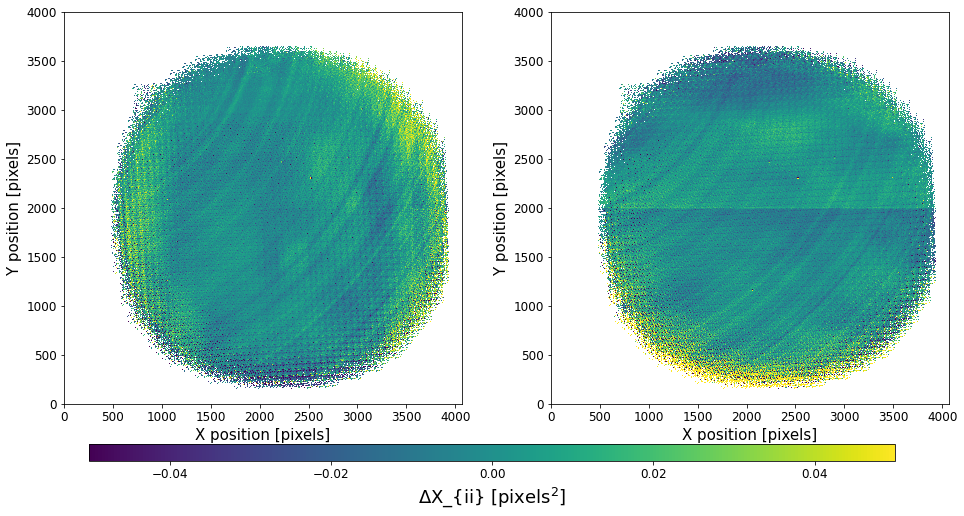

In [87]:
plot_deltaT_heatmap_comp(itl)

The heatmap shows the difference from the mean(Ixx+Iyy) for all exposures.

In [161]:
MAX = 0.07
fradius = 145

In [162]:
def mask_image(self,var,MAX=0.07,fradius=150):
    dmap = {'dT':self.dT,'dXX':self.dXX,'dYY':self.dYY,'dXY':self.dXY,'dX':self.dX,'dY':self.dY,'dR':self.dR2}
    nbins = 400
    bins = [407,400] #approx. 10x10 px^2 binning
    dT_mean, x_edge, y_edge, binidx = binned_statistic_2d(self.xfltr_flat, self.yfltr_flat, dmap[var], 'mean',
                                                          range=[[0,4072],[0,4000]], bins=bins)
                                                          #mean is significantly faster calculation
    x, y = np.meshgrid(x_edge, y_edge)
    #mask,lmtd = get_mask(dT_mean,MAX=0.07,fcenter=[x0,y0])
    lmtd = np.where((dT_mean>MAX) | (dT_mean<-MAX),0,dT_mean)

    xc,yc = np.median(self.xfltr_flat),np.median(self.yfltr_flat)
    x0,y0 = np.argmin(np.abs(x_edge-xc)), np.argmin(np.abs(y_edge-yc))

    Mask = np.zeros(lmtd.shape)
    for i in range(lmtd.shape[0]):
        for j in range(lmtd.shape[1]):
            if (i-x0)**2 + (j-y0)**2 < fradius**2:
                Mask[i,j] = 1
    Mask = np.where(Mask==0,np.nan,Mask)
    dT_mean = lmtd*Mask
    return x,y,dT_mean

In [163]:
x,y,dT_mean =  mask_image(itl,'dX',MAX=0.07,fradius=160)

In [164]:
rad = 1900

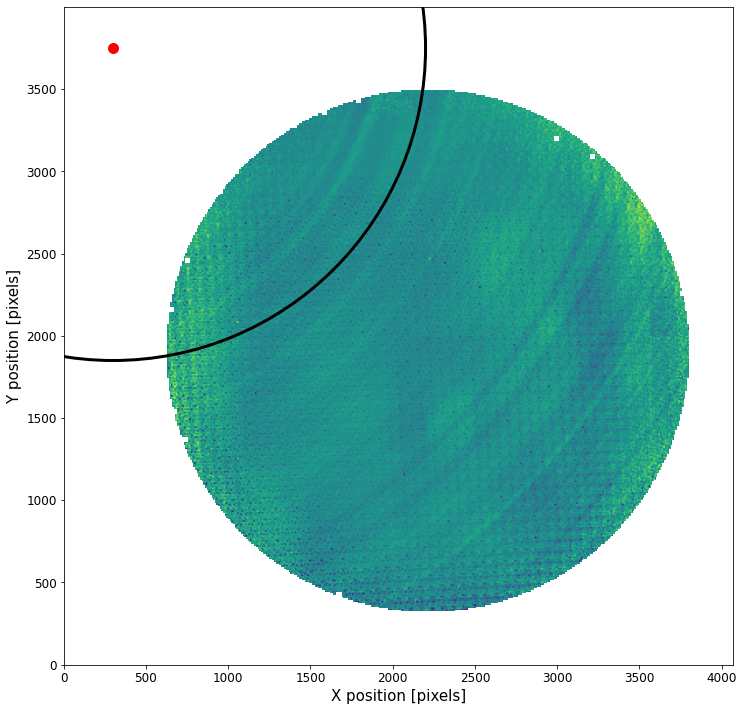

In [186]:
resized = cv2.resize(dT_mean.T,(4072,4000), interpolation = cv2.INTER_AREA)

fig, axes = plt.subplots(figsize = (12,13))

dx = -300
xc,yc = 0-dx, 3900+dx/2
im1 = axes.imshow(resized,origin='lower')
plt.scatter(xc,yc,s=100,color='r')
Drawing_colored_circle = plt.Circle(( xc , yc ), rad ,fill = False,lw=3)
axes.add_artist( Drawing_colored_circle )
axes.set_xlabel('X position [pixels]', fontsize=15)
axes.set_ylabel('Y position [pixels]', fontsize=15)
axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)
axes.set_aspect('equal')

In [166]:
# lims = np.percentile(itl.xfltr_flat,[0,100])
# maxR = lims[1]-lims[0]

(1200.0, 3749.5)

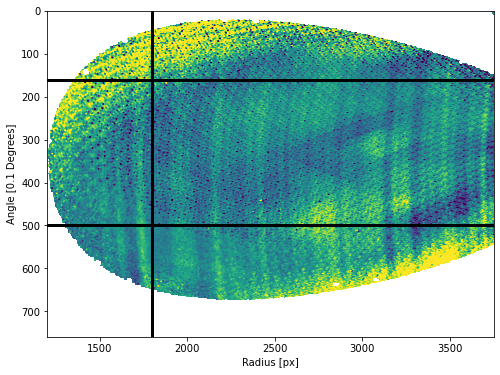

In [191]:
resized = cv2.resize(dT_mean.T,(4072,4000), interpolation = cv2.INTER_AREA)
start = 1800
id0,idend=160,500

#xc,yc = 0, 3850
maxR = np.floor(np.sqrt(xc**2+yc**2))
image = resized

margin = 1 # Cut off the outer 10% of the image
# radius resolution, angular resolution
polar_img = cv2.warpPolar(image, (int(maxR), 3600), (xc,yc), image.shape[0]*margin, cv2.WARP_POLAR_LINEAR)
# Rotate it sideways to be more visually pleasing
polar_img = polar_img[2850-10:,100:]

fig, axes = plt.subplots(figsize = (8,6))
axes.set_ylabel("Angle [0.1 Degrees]")
axes.set_xlabel("Radius [px]")
#axes.vlines(start,0,900,alpha=0.5)

axes.axvline(start,color='k',lw=3)
axes.axhline(id0,color='k',lw=3)
axes.axhline(idend,color='k',lw=3)

axes.imshow(polar_img,vmin=-0.02,vmax=0.02)
axes.set_aspect('auto')
plt.xlim(1200,)

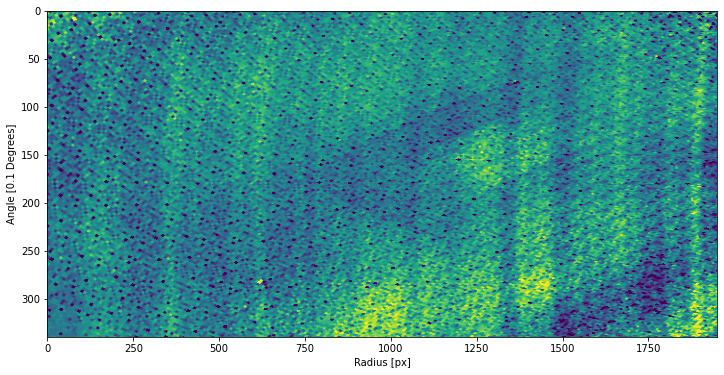

In [192]:
fig, axes = plt.subplots(figsize = (12,6))
axes.set_ylabel("Angle [0.1 Degrees]")
axes.set_xlabel("Radius [px]")
#axes.vlines(4900,0,900,alpha=0.5)
axes.imshow(polar_img[id0:idend,start:],vmin=-0.02,vmax=0.02)
# axes.vlines(1150,0,290,color='k')
axes.set_aspect('auto')

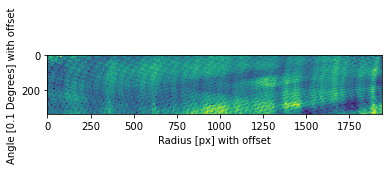

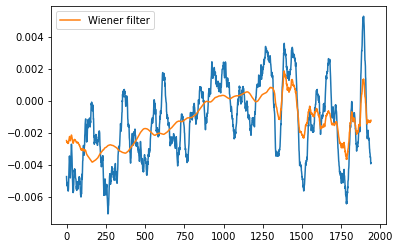

In [199]:
from scipy.signal.signaltools import wiener
imgplot = 1
#570,680
#start = 2700
cutout = polar_img[id0:idend,start:-10]
if imgplot:
    plt.ylabel("Angle [0.1 Degrees] with offset")
    plt.xlabel("Radius [px] with offset")
    plt.vlines(4900,0,900,alpha=0.5)
    plt.imshow(cutout,vmin=-0.02,vmax=0.02),plt.show()
    
freq=324
tr = cutout.mean(axis=0)
plt.plot(tr)
plt.plot(wiener(tr,freq),label='Wiener filter')

filteredTR = wiener(tr- wiener(tr,freq),4)
adjustedtrSG = np.concatenate((np.zeros(start),wiener(tr,10)))
plt.legend()

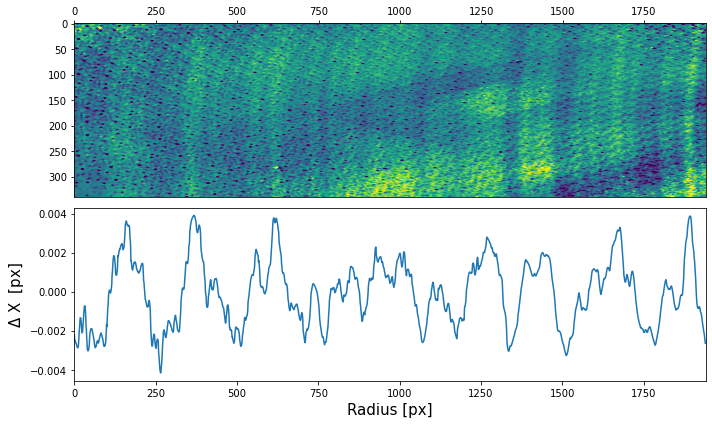

In [194]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].imshow(cutout,vmin=-0.02,vmax=0.02)
axes[0].xaxis.tick_top()
axes[1].plot(filteredTR)
axes[1].set_xlim(xmin=0,xmax=len(filteredTR))
axes[1].set_aspect('auto')
axes[0].set_aspect('auto')
axes[1].set_xlabel("Radius [px]",fontsize=15)
axes[1].set_ylabel(r"$\Delta$ X  [px]",fontsize=15)
plt.tight_layout()

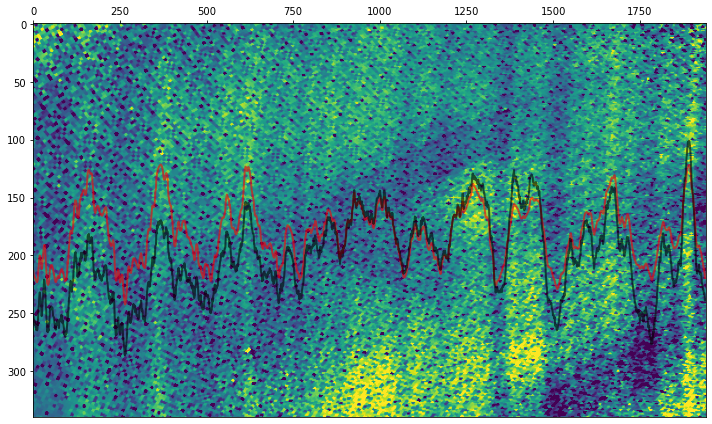

In [198]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
axes.imshow(cutout,vmin=-0.015,vmax=0.015)
axes.xaxis.tick_top()
AX=plt.gca()
AX.plot(-filteredTR*15000+180,'red',alpha=0.6,lw=2)
AX.plot(-tr*15000+180,'k',alpha=0.6,lw=2)
AX.grid(False)
AX.set_xlim(xmin=0,xmax=len(filteredTR))
axes.set_aspect('auto')
plt.tight_layout()

In [ ]:
def plot_tree_ring_profile(self):
    xbins = 256
    ybins = 250
    nbins = 200

    rad_bins, dT_r_mean, bin_width_r, dT_err1 = mkProfile(self.r, self.dT, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
    x_bins, dT_x_top_mean, bin_width_x, dT_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dT[self.top_amp_mask], nx=nbins, 
                                                             xmin=0, xmax=4096)
    x_bins, dT_x_bottom_mean, bin_width_x, dT_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dYY[self.bottom_amp_mask], 
                                                               nx=nbins, xmin=0, xmax=4096)
    y_bins, dT_y_mean, bin_width_y, dT_err4 = mkProfile(self.yfltr_flat, self.dYY, nx=nbins, xmin=0, xmax=4002)

    fig, axes = plt.subplots(3,1, figsize = (16,24))

    x_axis=np.linspace(0,4000*np.sqrt(2),150)

    axes[0].errorbar(rad_bins, dT_r_mean, xerr=bin_width_r, yerr=dT_err1)
    axes[0].plot(x_axis, x_axis*0, c='k', alpha=0.5)
    axes[0].set_title(r'$\Delta$T=$\Delta$XX+$\Delta$YY vs. Radial distance from tree ring center', fontsize=20)
    axes[0].set_xlabel('Radius [pixels]', fontsize=15)
    axes[0].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
    axes[0].set_ylim((-0.01, 0.01))
    axes[0].set_xlim(0,5000.)
    axes[0].tick_params(axis='x', labelsize=12)
    axes[0].tick_params(axis='y', labelsize=12)

    axes[1].errorbar(x_bins, dT_x_top_mean, xerr=bin_width_x, yerr=dT_err2, label='Top amplifiers only')
    axes[1].errorbar(x_bins, dT_x_bottom_mean, xerr=bin_width_x, yerr=dT_err3, label='Bottom amplifiers only')
    axes[1].plot(x_axis, x_axis*0, c='k', alpha=0.5)
    axes[1].set_title(r'$\Delta$T vs. X', fontsize=20)
    axes[1].set_xlabel('X position [pixels]', fontsize=15)
    axes[1].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
    axes[1].set_xlim((0, 4396))
    axes[1].set_ylim((-0.01, 0.01))
    axes[1].tick_params(axis='x', labelsize=12)
    axes[1].tick_params(axis='y', labelsize=12)
    axes[1].legend(loc='lower left', fontsize=15)


    axes[2].errorbar(x_bins, dT_y_mean, xerr=bin_width_y, yerr=dT_err4)
    axes[2].plot(x_axis, x_axis*0, c='k', alpha=0.5)
    axes[2].set_title(r'$\Delta$T vs. Y', fontsize=20)
    axes[2].set_xlabel('Y position [pixels]', fontsize=15)
    axes[2].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
    axes[2].set_xlim((0, 4002))
    axes[2].set_ylim((-0.015, 0.015))
    axes[2].tick_params(axis='x', labelsize=12)
    axes[2].tick_params(axis='y', labelsize=12)


In [ ]:
plot_tree_ring_profile(old)

In [ ]:
plot_tree_ring_profile(new2)

In [ ]:
def plot_tree_ring_profile_both(self,self2):
    xbins = 256
    ybins = 250
    nbins = 200

    fig, axes = plt.subplots(3,1, figsize = (16,24))
    x_axis=np.linspace(0,4000*np.sqrt(2),150)
    offset = 0.
    datas = [self,self2]
    for i,self in enumerate(datas):
        rad_bins, dT_r_mean, bin_width_r, dT_err1 = mkProfile(self.r, self.dT, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
        x_bins, dT_x_top_mean, bin_width_x, dT_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dT[self.top_amp_mask], nx=nbins, 
                                                                 xmin=0, xmax=4096)
        x_bins, dT_x_bottom_mean, bin_width_x, dT_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dYY[self.bottom_amp_mask], 
                                                                   nx=nbins, xmin=0, xmax=4096)
        y_bins, dT_y_mean, bin_width_y, dT_err4 = mkProfile(self.yfltr_flat, self.dYY, nx=nbins, xmin=0, xmax=4002)

        axes[0].errorbar(rad_bins, dT_r_mean, xerr=bin_width_r, yerr=dT_err1)
        axes[0].plot(x_axis, x_axis*0, c='k', alpha=0.5)
        axes[0].set_title(r'$\Delta$T=$\Delta$XX+$\Delta$YY vs. Radial distance from tree ring center', fontsize=20)
        axes[0].set_xlabel('Radius [pixels]', fontsize=15)
        axes[0].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
        axes[0].set_ylim((-0.01, 0.01))
        axes[0].set_xlim(0,5000.)
        axes[0].tick_params(axis='x', labelsize=12)
        axes[0].tick_params(axis='y', labelsize=12)
        
        if i==1:
            offset -= 296.
        axes[1].errorbar(x_bins+offset, dT_x_top_mean, xerr=bin_width_x, yerr=dT_err2, label='Top amplifiers only')
        #axes[1].errorbar(x_bins, dT_x_bottom_mean, xerr=bin_width_x, yerr=dT_err3, label='Bottom amplifiers only')
        axes[1].plot(x_axis, x_axis*0, c='k', alpha=0.5)
        axes[1].set_title(r'$\Delta$T vs. X', fontsize=20)
        axes[1].set_xlabel('X position [pixels]', fontsize=15)
        axes[1].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
        axes[1].set_xlim((150, 4396))
        axes[1].set_ylim((-0.01, 0.01))
        axes[1].tick_params(axis='x', labelsize=12)
        axes[1].tick_params(axis='y', labelsize=12)
        axes[1].legend(loc='lower left', fontsize=15)


        axes[2].errorbar(x_bins, dT_y_mean, xerr=bin_width_y, yerr=dT_err4)
        axes[2].plot(x_axis, x_axis*0, c='k', alpha=0.5)
        axes[2].set_title(r'$\Delta$T vs. Y', fontsize=20)
        axes[2].set_xlabel('Y position [pixels]', fontsize=15)
        axes[2].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
        axes[2].set_xlim((0, 4002))
        axes[2].set_ylim((-0.015, 0.015))
        axes[2].tick_params(axis='x', labelsize=12)
        axes[2].tick_params(axis='y', labelsize=12)


In [ ]:
#old2.xfltr_flat = tt(old.xfltr_flat)

In [ ]:
plot_tree_ring_profile_both(new2,old2)

In [ ]:
def plot_tree_ring_profile_stripes_both(self,self2):
    fig2, axes2 = plt.subplots(1, 8, figsize=(16,16))

    x_axis=np.linspace(0,4000*np.sqrt(2),150)
    nbins=200
    datas = [self,self2]
    for self in datas:
        for i in range(8):
            y_bins, dT_y_mean, bin_width, dT_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dT[self.x_amp_list[i]], nx=nbins, 
                                                                xmin=0, xmax=4002)
            axes2[i].errorbar(dT_y_mean, y_bins, yerr=bin_width, xerr=dT_err4)
            axes2[i].plot(x_axis*0, x_axis, c='k', alpha=0.5)
            axes2[i].set_ylim((0, 4002))
            axes2[i].set_xlim((-0.015, 0.015))
            axes2[i].tick_params(axis='y', labelleft=False)
            axes2[i].tick_params(axis='x', labelsize=12)

        axes2[0].tick_params(axis='y', labelsize=12, labelleft=True)
        axes2[0].set_ylabel('Y position [pixels]', fontsize=15)
        axes2[3].set_title(r'$\Delta$T=$\Delta$XX+$\Delta$YY vs. Y', fontsize=20)
        axes2[3].set_xlabel(r'$\Delta$T [pixels$^2$]', fontsize=15)

In [ ]:
plot_tree_ring_profile_stripes_both(new,old)

In [ ]:
plot_tree_ring_profile_stripes_both(new,old)

In [ ]:
def plot_tree_ring_profile_stripes_difference(self,self2):
    fig2, axes2 = plt.subplots(1, 8, figsize=(16,16))

    x_axis=np.linspace(0,4000*np.sqrt(2),150)
    nbins=200
    
    for i in range(8):
        y_bins, dT_y_mean, bin_width, dT_err4 = mkProfile(self.yfltr_flat[self.x_amp_list[i]], self.dT[self.x_amp_list[i]], nx=nbins, 
                                                xmin=0, xmax=4002)
    
        y_bins2, dT_y_mean2, bin_width2, dT_err42 = mkProfile(self2.yfltr_flat[self2.x_amp_list[i]], self2.dT[self2.x_amp_list[i]], nx=nbins, 
                                                xmin=0, xmax=4002)

    
        axes2[i].errorbar(dT_y_mean-dT_y_mean2, y_bins, yerr=bin_width, xerr=(dT_err4**2+dT_err42**2)**(0.5))
        axes2[i].plot(x_axis*0, x_axis, c='k', alpha=0.5)
        axes2[i].set_ylim((0, 4002))
        axes2[i].set_xlim((-0.015, 0.015))
        axes2[i].tick_params(axis='y', labelleft=False)
        axes2[i].tick_params(axis='x', labelsize=12)

    axes2[0].tick_params(axis='y', labelsize=12, labelleft=True)
    axes2[0].set_ylabel('Y position [pixels]', fontsize=15)
    axes2[3].set_title(r'$\Delta$T$_{new}-\Delta$T$_{old}$ vs. Y', fontsize=20)
    axes2[3].set_xlabel(r'$\Delta$T [pixels$^2$]', fontsize=15)

In [ ]:
plot_tree_ring_profile_stripes_difference(new,old)

## DeltaT profiles

In [ ]:
self = new2

In [ ]:
nbins = 400
bins=[409,400] #approx. 10x10 px^2 binning

dT_mean, x_edge, y_edge, binidx = binned_statistic_2d(self.xfltr_flat, self.yfltr_flat, self.dYY, 'mean',
                                                      range=[[0,4096],[0,4004]], bins=bins)

fig, axes = plt.subplots(figsize = (12,13))

x, y = np.meshgrid(x_edge, y_edge)

im0 = axes.pcolormesh(x, y, dT_mean.T, vmin=-0.08, vmax=0.08)
axes.set_xlabel('X position [pixels]', fontsize=20)
axes.set_ylabel('Y position [pixels]', fontsize=20)
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)
axes.set_aspect('equal')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
cbar = fig.colorbar(im0, cax= cbar_ax, orientation='horizontal')
cbar.set_label(r'$\Delta$YY [$\mathrm{pixels}^2$]', fontsize=20)
cbar.ax.tick_params(labelsize=15)

In [ ]:
self= old

In [ ]:
xbins = 256
ybins = 250
nbins = 200

rad_bins, dT_r_mean, bin_width_r, dT_err1 = mkProfile(self.r, self.dT, nx=nbins, xmin=0, xmax=4000*np.sqrt(2))
x_bins, dT_x_top_mean, bin_width_x, dT_err2 = mkProfile(self.xfltr_flat[self.top_amp_mask], self.dT[self.top_amp_mask], nx=nbins, 
                                                         xmin=0, xmax=4096)
x_bins, dT_x_bottom_mean, bin_width_x, dT_err3 = mkProfile(self.xfltr_flat[self.bottom_amp_mask], self.dYY[self.bottom_amp_mask], 
                                                           nx=nbins, xmin=0, xmax=4096)
y_bins, dT_y_mean, bin_width_y, dT_err4 = mkProfile(self.yfltr_flat, self.dYY, nx=nbins, xmin=0, xmax=4002)

fig, axes = plt.subplots(3,1, figsize = (16,24))

x_axis=np.linspace(0,4000*np.sqrt(2),150)

axes[0].errorbar(rad_bins, dT_r_mean, xerr=bin_width_r, yerr=dT_err1)
axes[0].plot(x_axis, x_axis*0, c='k', alpha=0.5)
axes[0].set_title(r'$\Delta$T=$\Delta$XX+$\Delta$YY vs. Radial distance from tree ring center', fontsize=20)
axes[0].set_xlabel('Radius [pixels]', fontsize=15)
axes[0].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
# axes[0].set_ylim((-0.01, 0.01))
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

axes[1].errorbar(x_bins, dT_x_top_mean, xerr=bin_width_x, yerr=dT_err2, label='Top amplifiers only')
axes[1].errorbar(x_bins, dT_x_bottom_mean, xerr=bin_width_x, yerr=dT_err3, label='Bottom amplifiers only')
axes[1].plot(x_axis, x_axis*0, c='k', alpha=0.5)
axes[1].set_title(r'$\Delta$T vs. X', fontsize=20)
axes[1].set_xlabel('X position [pixels]', fontsize=15)
axes[1].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
axes[1].set_xlim((0, 4096))
# axes[1].set_ylim((-0.01, 0.01))
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend(loc='lower left', fontsize=15)
   
    
axes[2].errorbar(x_bins, dT_y_mean, xerr=bin_width_y, yerr=dT_err4)
axes[2].plot(x_axis, x_axis*0, c='k', alpha=0.5)
axes[2].set_title(r'$\Delta$T vs. Y', fontsize=20)
axes[2].set_xlabel('Y position [pixels]', fontsize=15)
axes[2].set_ylabel(r'$\Delta$T [pixels$^2$]', fontsize=15)
axes[2].set_xlim((0, 4002))
# axes[2].set_ylim((-0.015, 0.015))
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)


In [ ]:
from plot_calibration import *

In [ ]:
plot_spot_second_moment_hist(old)

In [ ]:
plot_avg_spot_second_moment_hist(new)

In [ ]:
plot_avg_spot_second_moment_hist(old)

In [ ]:
plot_avg_exposure_second_moment_hist(new)

In [ ]:
plot_avg_exposure_second_moment_hist(old)

In [ ]:
new.xx_med_3.size

In [ ]:
plot_second_moment_spot_mean(new)

In [ ]:
plot_second_moment_spot_mean(old)

In [ ]:
np.nanmin(old.x)

In [ ]:
np.nanmin(new.x)

In [ ]:
plot_second_moment_spot_mean_med(new)

In [ ]:
plot_second_moment_spot_mean_med(old)

In [ ]:
def plot_second_moment_spot_std_new(sc):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    im0 = axes[0].scatter(sc.x, sc.y, c=sc.xx_std, s=30, marker='o', vmin=0.0, vmax=0.3)
    im1 = axes[1].scatter(sc.x, sc.y, c=sc.yy_std, s=30, marker='o', vmin=0.0, vmax=0.3)
    #im0 = axes[0].scatter(sc.x, sc.y, c=sc.xx_std, s=30, marker='o', vmin=0.0, vmax=0.4)
    #im1 = axes[1].scatter(sc.x, sc.y, c=sc.yy_std, s=30, marker='o', vmin=0.0, vmax=0.4)
    
    axes[0].set_title(r'$\sigma_{xx}$', fontsize=25)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)
    axes[1].set_title(r'$\sigma_{yy}$', fontsize=25)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)
    
    fig.subplots_adjust(bottom=0.2)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
    cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(r'Error [$\mathrm{pixels}^2$]', fontsize=20)
    cbar.ax.tick_params(labelsize=12)
    
    plt.suptitle(f'{sc.pop} Population')
    plt.show()
    plt.close()

In [ ]:
plot_second_moment_spot_std(new)

In [ ]:
plot_second_moment_spot_std(old)

In [ ]:
plot_second_moment_spot_err(new)

In [ ]:
plot_second_moment_spot_err(old)

In [ ]:
plot_second_moment_sigma(new)

In [ ]:
plot_second_moment_sigma(old)

In [ ]:
plot_med_second_moment_hist(new)

In [ ]:
plot_med_second_moment_hist(old)

In [ ]:
plot_second_moment_sum(new)

In [ ]:
plot_second_moment_sum(old)

In [ ]:
def get_mask(dT_mean,xgrid,ygrid,MAX=0.067,fcenter=[203,174],fradius=200,naned=True):
    lmtd = np.where((dT_mean>MAX) | (dT_mean<-MAX),0,dT_mean)
    
    w = np.where(np.abs(dT_mean)>MAX)
    x0,y0 = np.argmin(np.abs(x_edge-np.median(xgrid[w]))), np.argmin(np.abs(y_edge-np.median(xgrid[w])))
    
    Mask = np.zeros(lmtd.shape)
    for i in range(lmtd.shape[0]):
        for j in range(lmtd.shape[1]):
            if (i-fcenter[0])**2 + (j-fcenter[1])**2 < fradius**2:
                Mask[i,j] = 1
    if naned:
        Mask = np.where(Mask==0,np.nan,Mask)
    return Mask, lmtd

In [ ]:
def plot_deltaT_heatmap(sc,MAX=0.07,fradius=160):
    nbins = 400
    bins = [407,400] #approx. 10x10 px^2 binning
    dT_mean, x_edge, y_edge, binidx = binned_statistic_2d(sc.xfltr_flat, sc.yfltr_flat, sc.dT, 'mean',
                                                          range=[[0,4072],[0,4000]], bins=bins)
                                                          #mean is significantly faster calculation
    fig, axes = plt.subplots(figsize = (12,13))
    
    x, y = np.meshgrid(x_edge, y_edge)
    #mask,lmtd = get_mask(dT_mean,MAX=0.07,fcenter=[x0,y0])
    lmtd = np.where((dT_mean>MAX) | (dT_mean<-MAX),0,dT_mean)
    
    xc,yc = np.median(sc.xfltr_flat),np.median(sc.yfltr_flat)
    x0,y0 = np.argmin(np.abs(x_edge-xc)), np.argmin(np.abs(y_edge-yc))
    
    Mask = np.zeros(lmtd.shape)
    for i in range(lmtd.shape[0]):
        for j in range(lmtd.shape[1]):
            if (i-x0)**2 + (j-y0)**2 < fradius**2:
                Mask[i,j] = 1
    Mask = np.where(Mask==0,np.nan,Mask)
    dT_mean = lmtd*Mask
    
    im0 = axes.pcolormesh(x, y, dT_mean.T, vmin=-0.05, vmax=0.05,alpha=0.9)
    #im0 = axes.pcolormesh(x, y, Mask.T,cmap='jet',alpha=0.5)
    plt.scatter(xc,yc,s=40,color='r')
    axes.set_xlabel('X position [pixels]', fontsize=15)
    axes.set_ylabel('Y position [pixels]', fontsize=15)
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)
    axes.set_aspect('equal')
    
    fig.subplots_adjust(bottom=0.2)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])
    cbar = fig.colorbar(im0, cax= cbar_ax, orientation='horizontal')
    cbar.set_label(r'$\Delta$T [$\mathrm{pixels}^2$]', fontsize=18)
    cbar.ax.tick_params(labelsize=12)
    
    plt.suptitle(f'{sc.pop} Population')
    plt.show()
    plt.close()


In [ ]:
ilo, ihi = np.percentile(new.dT,[25,75])
iqr = 0.5*(ihi-ilo)

cut_low, cut_hig = ilo-1.5*iqr, ihi+1.5*iqr

print('low, upper bounds: %.4f, %.4f'%(cut_low, cut_hig))
#print('range: %.4f'%(cut_hig-cut_low))

In [ ]:
import cv2

In [ ]:
plot_deltaT_heatmap(new)

In [ ]:
plot_deltaT_heatmap(old)

In [ ]:
plot_deltaXX_heatmap(new)

In [ ]:
plot_deltaXX_heatmap(old)

In [ ]:
plot_deltaYY_heatmap(new)

In [ ]:
plot_deltaYY_heatmap(old)

In [ ]:
def plot_second_moment_spot_mean(sc):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    im0 = axes[0].scatter(sc.x, sc.y, c=sc.xx_mean, s=30, marker='o')
    im1 = axes[1].scatter(sc.x, sc.y, c=sc.yy_mean, s=30, marker='o')
    
    axes[0].set_title(r'$I_{xx}$ (mean)', fontsize=20)
    axes[0].tick_params(axis='x', labelsize=12)
    axes[0].tick_params(axis='y', labelsize=12)
    axes[1].set_title(r'$I_{yy}$ (mean)', fontsize=20)
    axes[1].tick_params(axis='x', labelsize=12)
    axes[1].tick_params(axis='y', labelsize=12)
    
    fig.subplots_adjust(bottom=0.2)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
    cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(r'[$\mathrm{pixels}^2$]', fontsize=18)
    cbar.ax.tick_params(labelsize=12)
    
    plt.suptitle(f'{sc.pop} Population')
    plt.show()
    plt.close()
    

In [ ]:
#
#plot_avg_exposure_second_moment_hist(e2v)
#plot_second_moment_spot_mean(e2v)
#plot_second_moment_spot_med(e2v)
#plot_second_moment_spot_mean_med(e2v)
#plot_second_moment_spot_std(e2v)
#plot_second_moment_spot_err(e2v)
#plot_second_moment_sigma(e2v)
#plot_med_second_moment_hist(e2v)
#plot_second_moment_sum(e2v)
#plot_deltaT_heatmap(e2v)
#plot_deltaXX_heatmap(e2v)
#plot_deltaYY_heatmap(e2v)
#plot_deltaXY_heatmap(e2v)

# Comparasion

In [ ]:
ITL = new
e2v = old

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
#im0 = axes[0].scatter(ITL.x[ITL.spot_filter], ITL.y[ITL.spot_filter], c=ITL.xxmedfltr+ITL.yymedfltr, s=30, marker='o', vmin=10, vmax=11)
#im1 = axes[1].scatter(e2v.x[e2v.spot_filter], e2v.y[e2v.spot_filter], c=e2v.xxmedfltr+e2v.yymedfltr, s=30, marker='o', vmin=10, vmax=11)
im0 = axes[0].scatter(ITL.x, ITL.y, c=ITL.xx_med.T+ITL.yy_med, s=30, marker='o', vmin=10, vmax=11)
im1 = axes[1].scatter(e2v.x, e2v.y, c=e2v.xx_med+e2v.yy_med, s=30, marker='o', vmin=10, vmax=11)

axes[0].set_title(r'$med(I_{xx}) + med(I_{yy})$ (new w/ Butler)', fontsize=20)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[1].set_title(r'$med(I_{xx}) + med(I_{yy})$ (old)', fontsize=20)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

axes[0].set_facecolor('grey')
axes[1].set_facecolor('grey')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'[$\mathrm{pixels}^2$]', fontsize=18)
cbar.ax.tick_params(labelsize=12)

#plt.savefig('compare_calibration.png', bbox_inches='tight')
#plt.close()

In [ ]:
49*49

In [ ]:
fig, axes = plt.subplots(figsize = (8,8))

#fltr = new.spot_filter & old.spot_filter
#im = axes.scatter(new.x[fltr], new.y[fltr], c=(new.xx_med+new.yy_med)[fltr]-(old.xx_med+old.yy_med)[fltr], s=30, marker='o')

#im = axes.scatter(new.x, new.y, c=(new.xx_med+new.yy_med)-(old.xx_med+old.yy_med), s=30, marker='o', vmin=-0.1, vmax=-0.01)
f = 105 # mm
s = 700 # mm
alpha = f/s
# 10 microns per pixel
im = axes.scatter(new.x, new.y, c=np.sqrt((ttx(new.xx_med+new.yy_med))**2 + alpha * (70/10)**2)-(old.xx_med+old.yy_med), s=30, marker='o', vmax=0.84)

axes.set_title(r'$med(I_{xx}) + med(I_{yy})$ (Butler - eotest)', fontsize=20)
axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)

axes.set_facecolor('grey')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'[$\mathrm{pixels}^2$]', fontsize=18)
cbar.ax.tick_params(labelsize=12)

plt.show()

In [ ]:
np.flip(np.arange(0,49*49).reshape(49,49),axis=0)[:,0]

In [ ]:
np.arange(0,49*49).reshape(49,49)[:,0]

In [ ]:
new.x_arr[:,0].reshape(49,49)[0]

In [ ]:
old.x_arr[:,0].reshape(49,49)[0]

In [ ]:
# fig, axes = plt.subplots(figsize = (8,8))

# #fltr = ITL.spot_filter & e2v.spot_filter
# #im = axes.scatter(ITL.x[fltr], ITL.y[fltr], c=(ITL.xx_med+ITL.yy_med)[fltr]-(e2v.xx_med+e2v.yy_med)[fltr], s=30, marker='o')

# #im = axes.scatter(ITL.x, ITL.y, c=(ITL.xx_med+ITL.yy_med)-(e2v.xx_med+e2v.yy_med), s=30, marker='o', vmin=-0.1, vmax=-0.01)
# f = 105 # mm
# s = 700 # mm
# alpha = f/s
# # 10 microns per pixel
# im = axes.scatter(ITL.x, ITL.y, c=np.sqrt(((ITL.xx_med+ITL.yy_med))**2 + alpha * (70/10)**2)-(e2v.xx_med+e2v.yy_med), s=30, marker='o')

# axes.set_title(r'$med(I_{xx}) + med(I_{yy})$ (new-old)', fontsize=20)
# axes.tick_params(axis='x', labelsize=12)
# axes.tick_params(axis='y', labelsize=12)

# axes.set_facecolor('grey')

# fig.subplots_adjust(bottom=0.2)
# cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
# cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# cbar.set_label(r'[$\mathrm{pixels}^2$]', fontsize=18)
# cbar.ax.tick_params(labelsize=12)

# plt.show()

In [ ]:
from scipy import stats

fltr = ITL.spot_filter & e2v.spot_filter
ITL_calibration = (ITL.xx_med + ITL.yy_med)[fltr]
e2v_calibration = (e2v.xx_med + e2v.yy_med)[fltr]

pvalue = stats.ks_2samp(ITL_calibration, e2v_calibration)[1]
print(f'K--S test p-value: {pvalue}')

In [ ]:
fpr = [np.count_nonzero(np.isnan(new.xx_arr[:,i])) for i in range(1600)]
fpro= [np.count_nonzero(np.isnan(old.xx_arr[:,i])) for i in range(1600)]

In [ ]:
plt.hist(fpr,bins=np.linspace(0,30,21),label='Alex mod.')
plt.hist(fpro,bins=np.linspace(0,30,21),histtype='step',lw=3,label='old')

plt.yscale('log')
plt.axvline(12,color='k',ls='--',lw=2)
plt.xlabel('# missing spots',fontsize=18)
plt.legend(fontsize=12)

# Flux Bimodal

In [ ]:
e2v= new

In [ ]:
pop_1 = (e2v.expnum_arr < 650)
pop_2 = ((e2v.expnum_arr >= 650) & (e2v.expnum_arr < 1200))
pop_3 = ((e2v.expnum_arr >= 1200) & (e2v.expnum_arr < 1450))
pop_4 = (e2v.expnum_arr >= 1450)

#-------------------------------------------------------------------------------
# First with a population separation
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(1,1, figsize = (16,8))

#axes.scatter(e2v.xy_arr[e2v.spot_filter], np.concatenate(np.array([np.reshape(e2v.xy_med, (-1,1)) for i in range(e2v.xy_arr.shape[1])]), axis=1)[e2v.spot_filter], s=1, c='k', alpha=0.005)

axes.scatter(e2v.xy_arr[e2v.spot_filter], np.concatenate(np.array([np.reshape(e2v.xy_med, (-1,1)) for i in range(e2v.xy_arr.shape[1])]), axis=1)[e2v.spot_filter], s=1, c='k', alpha=0.005)

axes.set_xlabel('Measured [pixels$^2$]', fontsize=20)
axes.set_ylabel('Calibrated [pixels$^2$]', fontsize=20)
axes.set_title('$I_{xy}$', fontsize=20)
axes.set_xlim((-0.3, 0.8))
axes.set_ylim((-0.3, 0.8))
#axes.legend(loc='upper left')

#plt.show()
#plt.savefig('calibrated_measured.png')
#plt.close()



In [ ]:
#-------------------------------------------------------------------------------
fig, axes = plt.subplots(1,1, figsize = (16,8))

axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.xy_arr, axis=0), s=1, c='k',label='new SpotGrid Task')
axes.scatter(old.expnum_arr, np.nanmedian(old.xy_arr, axis=0), s=1, c='r',label='old SpotGrid Task')

#axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.xy_arr, axis=0), s=1, c='k')

axes.set_xlabel('Exposure Number', fontsize=20)
axes.set_ylabel('Median Moment [pixels$^2$]', fontsize=20)
axes.set_title('$I_{xy}$', fontsize=20)
axes.legend(fontsize=18)
#axes.set_xlim((-1, 1.5))
#axes.set_ylim((-1, 1))

In [ ]:
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(1,1, figsize = (16,8))

#axes.scatter(e2v.expnum_arr, np.nanmean(e2v.instFlux_arr, axis=0), s=1, c='k')

axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.instFlux_arr[e2v.spot_filter], axis=0), s=1, c='k', label='Med')
axes.scatter(e2v.expnum_arr, np.nanmean(e2v.instFlux_arr[e2v.spot_filter], axis=0), s=1, c='gray', label='Mean')

# axes.scatter(old.expnum_arr, np.nanmedian(old.instFlux_arr[old.spot_filter], axis=0), s=1, c='r', label='Med old')
# axes.scatter(old.expnum_arr, np.nanmean(old.instFlux_arr[old.spot_filter], axis=0), s=1, c='lightcoral', label='Mean old')

axes.set_xlabel('Exposure Number', fontsize=20)
axes.set_ylabel('Flux [?]', fontsize=20)
plt.legend(loc='upper right')


In [ ]:
fig, axes = plt.subplots(1,1, figsize = (16,8))

#axes.scatter(e2v.xy_arr[e2v.spot_filter], np.concatenate(np.array([np.reshape(e2v.xy_med, (-1,1)) for i in range(e2v.xy_arr.shape[1])]), axis=1)[e2v.spot_filter], s=1, c='k', alpha=0.005)

axes.scatter(e2v.xy_arr[e2v.spot_filter][:, pop_2 | pop_4], np.concatenate(np.array([np.reshape(e2v.xy_med, (-1,1)) for i in range(e2v.xy_arr.shape[1])]), axis=1)[e2v.spot_filter][:, pop_2 | pop_4], s=1, c='b', alpha=0.005, label='2 | 4')
axes.scatter(e2v.xy_arr[e2v.spot_filter][:, pop_1 | pop_3], np.concatenate(np.array([np.reshape(e2v.xy_med, (-1,1)) for i in range(e2v.xy_arr.shape[1])]), axis=1)[e2v.spot_filter][:, pop_1 | pop_3], s=1, c='r', alpha=0.005, label='1 | 3')

axes.set_xlabel('Measured [pixels$^2$]', fontsize=20)
axes.set_ylabel('Calibrated [pixels$^2$]', fontsize=20)
axes.set_title('$I_{xy}$', fontsize=20)
axes.set_xlim((-0.3, 0.8))
axes.set_ylim((-0.3, 0.8))

In [ ]:

fig, axes = plt.subplots(1,1, figsize = (16,8))

axes.axvspan(xmin=np.min(e2v.expnum_arr), xmax=650, color='r', alpha=0.5)
axes.axvspan(xmin=650, xmax=1200, color='b', alpha=0.5)
axes.axvspan(xmin=1200, xmax=1450, color='r', alpha=0.5)
axes.axvspan(xmin=1450, xmax=np.max(e2v.expnum_arr), color='b', alpha=0.5)
axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.xy_arr, axis=0), s=1, c='k')

#axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.xy_arr, axis=0), s=1, c='k')

axes.set_xlabel('Exposure Number', fontsize=20)
axes.set_ylabel('Median Moment [pixels$^2$]', fontsize=20)
axes.set_title('$I_{xy}$', fontsize=20)

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (16,8))

#axes.scatter(e2v.expnum_arr, np.nanmean(e2v.instFlux_arr, axis=0), s=1, c='k')

#axes.scatter(e2v.expnum_arr[pop_2 | pop_4], np.nanmedian(e2v.instFlux_arr[e2v.spot_filter][:, pop_2 | pop_4], axis=0), s=1, c='b', alpha=1, label='Med(2 | 4)')
#axes.scatter(e2v.expnum_arr[pop_1 | pop_3], np.nanmedian(e2v.instFlux_arr[e2v.spot_filter][:, pop_1 | pop_3], axis=0), s=1, c='r', alpha=1, label='Med(1 | 3)')
#
#axes.scatter(e2v.expnum_arr[pop_2 | pop_4], np.nanmean(e2v.instFlux_arr[e2v.spot_filter][:, pop_2 | pop_4], axis=0), s=1, c='b', alpha=0.5, label='Mean(2 | 4)')
#axes.scatter(e2v.expnum_arr[pop_1 | pop_3], np.nanmean(e2v.instFlux_arr[e2v.spot_filter][:, pop_1 | pop_3], axis=0), s=1, c='r', alpha=0.5, label='Mean(1 | 3)')

axes.axvspan(xmin=np.min(e2v.expnum_arr), xmax=650, color='r', alpha=0.5)
axes.axvspan(xmin=650, xmax=1200, color='b', alpha=0.5)
axes.axvspan(xmin=1200, xmax=1450, color='r', alpha=0.5)
axes.axvspan(xmin=1450, xmax=np.max(e2v.expnum_arr), color='b', alpha=0.5)
axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.instFlux_arr[e2v.spot_filter], axis=0), s=1, c='k', label='Med')
axes.scatter(e2v.expnum_arr, np.nanmean(e2v.instFlux_arr[e2v.spot_filter], axis=0), s=1, c='gray', label='Mean')

axes.set_xlabel('Exposure Number', fontsize=20)
axes.set_ylabel('Flux [?]', fontsize=20)
plt.legend(loc='upper right')

In [ ]:
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(1,1, figsize = (16,8))

#axes.scatter(e2v.expnum_arr, np.nanmean(e2v.instFlux_arr, axis=0), s=1, c='k')

axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.instFlux_arr[e2v.spot_filter], axis=0), s=1, c='k', label='Med')

axes.scatter(e2v.expnum_arr, np.nanmean(e2v.instFlux_arr[e2v.spot_filter], axis=0), s=1, c='gray', label='Mean')

axes.set_xlabel('Exposure Number', fontsize=20)
axes.set_ylabel('Flux [?]', fontsize=20)
plt.legend(loc='upper right')
#axes.set_title('$I_{xy}$', fontsize=20)
#axes.set_xlim((-1, 1.5))
#axes.set_ylim((-1, 1))

#plt.show()
plt.savefig('flux_expnum.png')
plt.close()

#-------------------------------------------------------------------------------
# Second with a population separation
#-------------------------------------------------------------------------------

fig, axes = plt.subplots(1,1, figsize = (16,8))

#axes.scatter(e2v.xy_arr[e2v.spot_filter], np.concatenate(np.array([np.reshape(e2v.xy_med, (-1,1)) for i in range(e2v.xy_arr.shape[1])]), axis=1)[e2v.spot_filter], s=1, c='k', alpha=0.005)

axes.scatter(e2v.xy_arr[e2v.spot_filter][:, pop_2 | pop_4], np.concatenate(np.array([np.reshape(e2v.xy_med, (-1,1)) for i in range(e2v.xy_arr.shape[1])]), axis=1)[e2v.spot_filter][:, pop_2 | pop_4], s=1, c='b', alpha=0.005, label='2 | 4')
axes.scatter(e2v.xy_arr[e2v.spot_filter][:, pop_1 | pop_3], np.concatenate(np.array([np.reshape(e2v.xy_med, (-1,1)) for i in range(e2v.xy_arr.shape[1])]), axis=1)[e2v.spot_filter][:, pop_1 | pop_3], s=1, c='r', alpha=0.005, label='1 | 3')
#axes.scatter(e2v.xy_arr[e2v.spot_filter][:, pop_2 | pop_4], np.nanmedian(e2v.xy_arr[e2v.spot_filter][:, pop_2 | pop_4], axis=1), s=1, c='b', alpha=0.005, label='2 | 4')
#axes.scatter(e2v.xy_arr[e2v.spot_filter][:, pop_1 | pop_3], np.nanmedian(e2v.xy_arr[e2v.spot_filter][:, pop_1 | pop_3], axis=1), s=1, c='r', alpha=0.005, label='1 | 3')

axes.set_xlabel('Measured [pixels$^2$]', fontsize=20)
axes.set_ylabel('Calibrated [pixels$^2$]', fontsize=20)
axes.set_title('$I_{xy}$', fontsize=20)
#axes.set_xlim((-1, 1.5))
#axes.set_ylim((-1, 1))
#axes.legend(loc='upper left')

#plt.show()
plt.savefig('calibrated_measured-separated.png')
plt.close()

#-------------------------------------------------------------------------------

fig, axes = plt.subplots(1,1, figsize = (16,8))

axes.axvspan(xmin=np.min(e2v.expnum_arr), xmax=650, color='r', alpha=0.5)
axes.axvspan(xmin=650, xmax=1200, color='b', alpha=0.5)
axes.axvspan(xmin=1200, xmax=1450, color='r', alpha=0.5)
axes.axvspan(xmin=1450, xmax=np.max(e2v.expnum_arr), color='b', alpha=0.5)
axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.xy_arr, axis=0), s=1, c='k')

#axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.xy_arr, axis=0), s=1, c='k')

axes.set_xlabel('Exposure Number', fontsize=20)
axes.set_ylabel('Median Moment [pixels$^2$]', fontsize=20)
axes.set_title('$I_{xy}$', fontsize=20)
#axes.set_xlim((-1, 1.5))
#axes.set_ylim((-1, 1))

#plt.show()
plt.savefig('moment_expnum-separated.png')
plt.close()

#-------------------------------------------------------------------------------

fig, axes = plt.subplots(1,1, figsize = (16,8))

#axes.scatter(e2v.expnum_arr, np.nanmean(e2v.instFlux_arr, axis=0), s=1, c='k')

#axes.scatter(e2v.expnum_arr[pop_2 | pop_4], np.nanmedian(e2v.instFlux_arr[e2v.spot_filter][:, pop_2 | pop_4], axis=0), s=1, c='b', alpha=1, label='Med(2 | 4)')
#axes.scatter(e2v.expnum_arr[pop_1 | pop_3], np.nanmedian(e2v.instFlux_arr[e2v.spot_filter][:, pop_1 | pop_3], axis=0), s=1, c='r', alpha=1, label='Med(1 | 3)')
#
#axes.scatter(e2v.expnum_arr[pop_2 | pop_4], np.nanmean(e2v.instFlux_arr[e2v.spot_filter][:, pop_2 | pop_4], axis=0), s=1, c='b', alpha=0.5, label='Mean(2 | 4)')
#axes.scatter(e2v.expnum_arr[pop_1 | pop_3], np.nanmean(e2v.instFlux_arr[e2v.spot_filter][:, pop_1 | pop_3], axis=0), s=1, c='r', alpha=0.5, label='Mean(1 | 3)')

axes.axvspan(xmin=np.min(e2v.expnum_arr), xmax=650, color='r', alpha=0.5)
axes.axvspan(xmin=650, xmax=1200, color='b', alpha=0.5)
axes.axvspan(xmin=1200, xmax=1450, color='r', alpha=0.5)
axes.axvspan(xmin=1450, xmax=np.max(e2v.expnum_arr), color='b', alpha=0.5)
axes.scatter(e2v.expnum_arr, np.nanmedian(e2v.instFlux_arr[e2v.spot_filter], axis=0), s=1, c='k', label='Med')
axes.scatter(e2v.expnum_arr, np.nanmean(e2v.instFlux_arr[e2v.spot_filter], axis=0), s=1, c='gray', label='Mean')

axes.set_xlabel('Exposure Number', fontsize=20)
axes.set_ylabel('Flux [?]', fontsize=20)
plt.legend(loc='upper right')
#axes.set_title('$I_{xy}$', fontsize=20)
#axes.set_xlim((-1, 1.5))
#axes.set_ylim((-1, 1))

#plt.show()
plt.savefig('flux_expnum-separated.png')
plt.close()

##-------------------------------------------------------------------------------
#
#fig, axes = plt.subplots(1,1, figsize = (16,8))
#
##vp_1_3 = axes.violinplot(dataset=e2v.instFlux_arr[e2v.spot_filter][:, pop_1 | pop_3][np.arange(0, len(e2v.expnum_arr[pop_1 | pop_3]), 10)],
##                         positions=e2v.expnum_arr[pop_1 | pop_3][np.arange(0, len(e2v.expnum_arr[pop_1 | pop_3]), 10)],
##                         showmeans=True,showmedians=True)
##vp_2_4 = axes.violinplot(dataset=e2v.instFlux_arr[e2v.spot_filter][:, pop_2 | pop_4][np.arange(0, len(e2v.expnum_arr[pop_2 | pop_4]), 10)],
##                         positions=e2v.expnum_arr[pop_2 | pop_4][np.arange(0, len(e2v.expnum_arr[pop_2 | pop_4]), 10)],
##                         showmeans=True,showmedians=True)
#vp_1_3 = axes.violinplot(dataset=e2v.instFlux_arr[e2v.spot_filter][:, pop_1 | pop_3],
#                         positions=e2v.expnum_arr[pop_1 | pop_3],
#                         showmeans=True,showmedians=True)
#vp_2_4 = axes.violinplot(dataset=e2v.instFlux_arr[e2v.spot_filter][:, pop_2 | pop_4],
#                         positions=e2v.expnum_arr[pop_2 | pop_4],
#                         showmeans=True,showmedians=True)
#for pc in vp_1_3['bodies']:
#    pc.set_facecolor('r')
#for pc in vp_2_4['bodies']:
#    pc.set_facecolor('b')
#for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
#    vp_1_3[partname].set_color('r')
#    vp_2_4[partname].set_color('b')
#
#axes.set_xlabel('Exposure Number', fontsize=20)
#axes.set_ylabel('Flux [?]', fontsize=20)
##axes.set_title('$I_{xy}$', fontsize=20)
##axes.set_xlim((-1, 1.5))
##axes.set_ylim((-1, 1))
#plt.show()
#plt.close()


In [ ]:
mypath = '/gpfs/slac/kipac/fs1/u/esteves/data/6865D/'

In [ ]:
cat_files = glob.glob(os.path.join(mypath, 'MC*.cat'))
expnum_arr = np.array([int(os.path.basename(f).split('_')[3]) for f in cat_files])
date_arr = np.array([int(os.path.basename(f).split('_')[2]) for f in cat_files])

In [ ]:
plt.hist(date_arr-date_arro)

In [ ]:
mypath = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6864D_dither/results/'
cat_files = glob.glob(os.path.join(mypath, 'MC*.cat'))
expnum_arro = np.array([int(os.path.basename(f).split('_')[3]) for f in cat_files])
date_arro = np.array([int(os.path.basename(f).split('_')[2]) for f in cat_files])

In [ ]:
expnum_arro

In [ ]:
os.path.basename(cat_files[0]).split('_')